In [81]:
import json
from pathlib import Path

# Load results for a specific problem
problem_id = "problem_6481"  # Your processed problem
results_dir = Path("rollout_results_no_ablation") / problem_id

# Load the sentence rollouts
with open(results_dir / "sentence_rollouts.json", 'r') as f:
    sentence_rollouts_no_ablation = json.load(f)

print(f"Loaded {len(sentence_rollouts_no_ablation)} sentence results")

Loaded 187 sentence results


In [82]:
sentence_rollouts_no_ablation[0].keys()

dict_keys(['problem_id', 'sentence_idx', 'sentence_text', 'function_tags', 'context_without_sentence', 'ground_truth_answer', 'num_rollouts', 'rollout_sentences', 'rollout_answer_correct', 'rollout_answer_correct_check', 'unique_responses', 'rollout_boxed_answers', 'cos_sims_llm', 'cos_sims_sentence', 'embedding_correlation', 'generation_params'])

In [83]:
def check_valid_list(list_rollouts):
  # Check if sentence_idx values are in order
    sentence_indices = [rollout.get('sentence_idx', -1) for rollout in list_rollouts]

    print(f"Found {len(list_rollouts)} rollouts")
    print(f"Sentence indices: {sentence_indices}")
    
    # Check if indices are consecutive starting from 0
    expected_indices = list(range(len(list_rollouts)))
    is_consecutive = sentence_indices == expected_indices
    
    print(f"Expected indices: {expected_indices}")
    print(f"Indices are consecutive from 0: {is_consecutive}")
    
    # Check if indices are sorted (but maybe not starting from 0)
    is_sorted = sentence_indices == sorted(sentence_indices)
    print(f"Indices are sorted: {is_sorted}")
    
    # Find any gaps or duplicates
    unique_indices = set(sentence_indices)
    has_duplicates = len(unique_indices) != len(sentence_indices)
    print(f"Has duplicate indices: {has_duplicates}")

In [84]:
import torch
import math
def calculate_kl_divergence_realmbird(rollout_answer_correct, cos_sims, similarity_threshold=0.8, next_rollout_answer_correct=[], batch=12):
    """
    Calculate KL divergence between answer correctness distributions for similar vs dissimilar rollouts.
    This follows the thought-anchors approach.
    
    Args:
        rollout_answer_correct: List of boolean correctness for each rollout
        cos_sims: Tensor of cosine similarities for each rollout
        similarity_threshold: Threshold for determining similar vs dissimilar
        
    Returns:
        dict: Contains KL divergences and group statistics
    """
    # remove more than the set batches
    cos_sims = cos_sims[:batch]
    rollout_answer_correct = rollout_answer_correct[:batch]
    next_rollout_answer_correct = next_rollout_answer_correct[:batch]

    # Ensure cos_sims is a tensor
    if not torch.is_tensor(cos_sims):
        cos_sims = torch.tensor(cos_sims, dtype=torch.float32)

    # Separate rollouts into similar and dissimilar groups
    similar_mask = cos_sims > similarity_threshold
    dissimilar_mask = ~similar_mask
    
    similar_correctness = [rollout_answer_correct[i] for i in range(len(rollout_answer_correct)) if similar_mask[i]]
    dissimilar_correctness = [rollout_answer_correct[i] for i in range(len(rollout_answer_correct)) if dissimilar_mask[i]]
    num_next_correct = sum(next_rollout_answer_correct)

    if len(dissimilar_correctness) == 0 or num_next_correct == 0:
        return {
            "kl_divergence": 0.0,
            "similar_group_size": len(similar_correctness),
            "dissimilar_group_size": len(dissimilar_correctness),
            "similar_accuracy": 0.0,
            "dissimilar_accuracy": 0.0,
            "error": "Insufficient data for KL divergence calculation"
        }
    
    # Calculate accuracy rates for each group
    # similar_accuracy = sum(similar_correctness) / len(similar_correctness)
    eps = 1e-8
    similar_accuracy_and_next = (sum(similar_correctness) + num_next_correct + eps) / (len(similar_correctness) + len(next_rollout_answer_correct) + 2 * eps)
    dissimilar_accuracy = (sum(dissimilar_correctness) + eps) / (len(dissimilar_correctness) + 2 * eps)

    p = dissimilar_accuracy
    q = similar_accuracy_and_next

    kl_div = p * math.log(p / q) + (1 - p) * math.log((1 - p) / (1 - q))
    
    return {
        "kl_divergence": float(kl_div),
        "similar_group_size": len(similar_correctness),
        "dissimilar_group_size": len(dissimilar_correctness),
        "similar_accuracy_and_next": similar_accuracy_and_next,
        "dissimilar_accuracy": dissimilar_accuracy
    }

In [85]:
sentence_rollouts_no_ablation[0].keys()

dict_keys(['problem_id', 'sentence_idx', 'sentence_text', 'function_tags', 'context_without_sentence', 'ground_truth_answer', 'num_rollouts', 'rollout_sentences', 'rollout_answer_correct', 'rollout_answer_correct_check', 'unique_responses', 'rollout_boxed_answers', 'cos_sims_llm', 'cos_sims_sentence', 'embedding_correlation', 'generation_params'])

In [86]:
def process_rollouts_kl_counterfactual_importance(rollouts, sent=True, correct_metric='rollout_answer_correct_check'):
  # check_valid_list(rollouts) # can be used to check if the rollouts are in order from 0 - x and no duplicates
  results = []
  for i in range(len(rollouts)-1):
        rollout = rollouts[i]
        #(rollout_answer_correct, cos_sims, similarity_threshold=0.8, next_rollout_answer_correct=[]):
        answer_correct = rollout[correct_metric]
        cos_sims_sent = rollout['cos_sims_sentence'] #uses sentence model like paper
        cos_sims_llm = rollout['cos_sims_llm'] # uses LLM tokenizer to see sim directly
        next_rollout_answer_correct = rollouts[i+1][correct_metric]
        sent_kl_divergence = calculate_kl_divergence_realmbird(answer_correct, cos_sims_sent, similarity_threshold=0.8, next_rollout_answer_correct=next_rollout_answer_correct)
        

        llm_kl_divergence = calculate_kl_divergence_realmbird(answer_correct, cos_sims_llm, similarity_threshold=0.8, next_rollout_answer_correct=next_rollout_answer_correct)

        if sent:
          has_sent_error = "error" in sent_kl_divergence
          if has_sent_error:
            # Set everything to 0 and add error field
            result = {
                "sentence_idx": rollout.get("sentence_idx", i),
                "sentence_category": rollout.get("function_tags", [""])[0],
                "kl_divergence_sent": sent_kl_divergence["kl_divergence"],
                "kl_divergence_llm":  llm_kl_divergence["kl_divergence"],
                "similar_group_size_sent": sent_kl_divergence["similar_group_size"],
                "dissimilar_group_size_sent": sent_kl_divergence["dissimilar_group_size"],
                "similar_group_size_llm": llm_kl_divergence["similar_group_size"],
                "dissimilar_group_size_llm": llm_kl_divergence["dissimilar_group_size"],
                "similar_accuracy_and_next": 0.0,
                "dissimilar_accuracy": 0.0,
                "error": "Insufficient data for KL divergence calculation"
            }
          else:
            # Normal processing
            result = {
                "sentence_idx": rollout.get("sentence_idx", i),
                "sentence_category": rollout.get("function_tags", [""])[0],
                "kl_divergence_sent": sent_kl_divergence["kl_divergence"],
                "kl_divergence_llm": llm_kl_divergence["kl_divergence"],
                "similar_group_size_sent": sent_kl_divergence["similar_group_size"],
                "dissimilar_group_size_sent": sent_kl_divergence["dissimilar_group_size"],
                "similar_group_size_llm": llm_kl_divergence["similar_group_size"],
                "dissimilar_group_size_llm": llm_kl_divergence["dissimilar_group_size"],
                "similar_accuracy_and_next": sent_kl_divergence.get("similar_accuracy_and_next", sent_kl_divergence.get("similar_accuracy", 0.0)),
                "dissimilar_accuracy": sent_kl_divergence["dissimilar_accuracy"]
            }
        else:
          has_llm_error = "error" in llm_kl_divergence
          if has_llm_error:
              # Set everything to 0 and add error field
              result = {
                  "sentence_idx": rollout.get("sentence_idx", i),
                  "sentence_category": rollout.get("function_tags", [""])[0],
                  "kl_divergence_sent": sent_kl_divergence["kl_divergence"],
                  "kl_divergence_llm":  llm_kl_divergence["kl_divergence"],
                  "similar_group_size_sent": sent_kl_divergence["similar_group_size"],
                  "dissimilar_group_size_sent": sent_kl_divergence["dissimilar_group_size"],
                  "similar_group_size_llm": llm_kl_divergence["similar_group_size"],
                  "dissimilar_group_size_llm": llm_kl_divergence["dissimilar_group_size"],
                  "similar_accuracy_and_next": 0.0,
                  "dissimilar_accuracy": 0.0,
                  "error": "Insufficient data for KL divergence calculation"
              }
          else:
              # Normal processing
              result = {
                  "sentence_idx": rollout.get("sentence_idx", i),
                  "sentence_category": rollout.get("function_tags", [""])[0],
                  "kl_divergence_sent": sent_kl_divergence["kl_divergence"],
                  "kl_divergence_llm": llm_kl_divergence["kl_divergence"],
                  "similar_group_size_sent": sent_kl_divergence["similar_group_size"],
                  "dissimilar_group_size_sent": sent_kl_divergence["dissimilar_group_size"],
                  "similar_group_size_llm": llm_kl_divergence["similar_group_size"],
                  "dissimilar_group_size_llm": llm_kl_divergence["dissimilar_group_size"],
                  "similar_accuracy_and_next": sent_kl_divergence.get("similar_accuracy_and_next", sent_kl_divergence.get("similar_accuracy", 0.0)),
                  "dissimilar_accuracy": sent_kl_divergence["dissimilar_accuracy"]
              }
        results.append(result)

        # print(f"Processing rollout for sentence: {rollout['sentence_text']}")
        # Add more processing logic as needed
  return results


In [87]:
kl_results_no_ablation_sent = process_rollouts_kl_counterfactual_importance(sentence_rollouts_no_ablation, sent=True)
kl_results_no_ablation_llm = process_rollouts_kl_counterfactual_importance(sentence_rollouts_no_ablation, sent=False)

In [88]:
def check_errors(kl_results):
    # Check number of errors in kl_results
    error_count = 0
    total_results = len(kl_results)

    for i, result in enumerate(kl_results):
        if "error" in result:
            error_count += 1
            print(f"Error at index {i}: {result['error']}")

    print(f"\nSummary:")
    print(f"Total results: {total_results}")
    print(f"Results with errors: {error_count}")
    print(f"Results without errors: {total_results - error_count}")
    print(f"Error rate: {error_count / total_results * 100:.2f}%")

    # Also check the specific error statistics
    if error_count > 0:
        print(f"\nError details:")
        error_results = [r for r in kl_results if "error" in r]
        print(f"Similar group sizes in errors: {[r['similar_group_size_sent'] for r in error_results]}")
        print(f"Dissimilar group sizes in errors: {[r['dissimilar_group_size_sent'] for r in error_results]}")

In [89]:
import json
from pathlib import Path

# Load ablation results for the same problem
ablation_results_dir = Path("rollout_results_ablation") / problem_id

# Load the sentence rollouts for ablation
with open(ablation_results_dir / "sentence_multi_head_ablation_rollouts.json", 'r') as f:
    sentence_rollouts_ablation = json.load(f)

print(f"Loaded {len(sentence_rollouts_ablation)} ablation sentence results")

Loaded 187 ablation sentence results


In [90]:
kl_divergences_sentences_ablation_result = process_rollouts_kl_counterfactual_importance(sentence_rollouts_ablation, sent=True)
kl_divergences_llm_ablation_result = process_rollouts_kl_counterfactual_importance(sentence_rollouts_ablation, sent=False)

In [91]:
# Extract KL divergence values using list comprehensions
kl_divergences_sentences_no_ablation = [result["kl_divergence_sent"] for result in kl_results_no_ablation_sent]
kl_divergences_llm_no_ablation = [result["kl_divergence_llm"] for result in kl_results_no_ablation_llm]


In [92]:
kl_divergences_llm_ablation = [result["kl_divergence_llm"] for result in kl_divergences_llm_ablation_result]
kl_divergences_sentences_ablation = [result["kl_divergence_sent"] for result in kl_divergences_llm_ablation_result]

In [93]:
from collections import defaultdict
# Filter and organize results by sentence category
def filter_by_category(kl_results):
    """
    Filter KL results by sentence category and extract relevant fields.
    
    Args:
        kl_results: List of KL result dictionaries
        category_filter: String to filter by category, or None for all
    
    Returns:
        List of dictionaries with filtered results
    """
    all_categories = set([result.get("sentence_category", "") for result in kl_results])
    filtered_results = defaultdict(list)
    
    for result in kl_results:
        # Apply category filter if specified
        category = result.get("sentence_category", "")
        filtered_result = { 
            "sentence_idx": result["sentence_idx"],
            "sentence_category": result["sentence_category"],
            "kl_divergence_sent": result["kl_divergence_sent"],
            "kl_divergence_llm": result["kl_divergence_llm"],
            "error": result.get("error", None)
        }
        filtered_results[category].append(filtered_result)
    
    return filtered_results


In [94]:
# Extract KL divergence values using list comprehensions
kl_divergences_sentences_no_ablation = [result["kl_divergence_sent"] for result in kl_results_no_ablation_sent]
kl_divergences_llm_no_ablation = [result["kl_divergence_llm"] for result in kl_results_no_ablation_llm]
kl_divergences_llm_ablation = [result["kl_divergence_llm"] for result in kl_divergences_llm_ablation_result]
kl_divergences_sentences_ablation = [result["kl_divergence_sent"] for result in kl_divergences_llm_ablation_result]

In [95]:
category_sentences_no_ablation = filter_by_category(kl_results_no_ablation_sent)
category_llm_no_ablation = filter_by_category(kl_results_no_ablation_llm)
category_sentences_ablation = filter_by_category(kl_divergences_sentences_ablation_result)
category_llm_ablation = filter_by_category(kl_divergences_llm_ablation_result)

In [96]:
category_sentences_no_ablation

defaultdict(list,
            {'problem_setup': [{'sentence_idx': 0,
               'sentence_category': 'problem_setup',
               'kl_divergence_sent': 0.37636963786036165,
               'kl_divergence_llm': 0.37636963786036165,
               'error': None}],
             'plan_generation': [{'sentence_idx': 1,
               'sentence_category': 'plan_generation',
               'kl_divergence_sent': 0.418494106194131,
               'kl_divergence_llm': 0.418494106194131,
               'error': None},
              {'sentence_idx': 7,
               'sentence_category': 'plan_generation',
               'kl_divergence_sent': 0.2327284759144602,
               'kl_divergence_llm': 0.0062431203339890565,
               'error': None},
              {'sentence_idx': 13,
               'sentence_category': 'plan_generation',
               'kl_divergence_sent': -1.455310012785428e-17,
               'kl_divergence_llm': 0.21130903045677343,
               'error': None},
      

Creating KL Divergence visualizations by sentence category...

KL Divergence by Category (Sentence Embeddings - No Ablation) - Statistics:
--------------------------------------------------
problem_setup: n=1, mean=0.3764, median=0.3764, std=0.0000
plan_generation: n=11, mean=0.4263, median=0.1671, std=0.5440
uncertainty_management: n=29, mean=0.3952, median=0.0870, std=0.8014
result_consolidation: n=15, mean=0.9230, median=0.0870, std=1.6710
fact_retrieval: n=109, mean=0.4127, median=0.0870, std=0.6813
active_computation: n=20, mean=0.7851, median=0.0955, std=1.1908
final_answer_emission: n=1, mean=0.0000, median=0.0000, std=0.0000


/tmp/ipykernel_2175398/1868092253.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(category_kl_values, labels=category_labels, patch_artist=True)


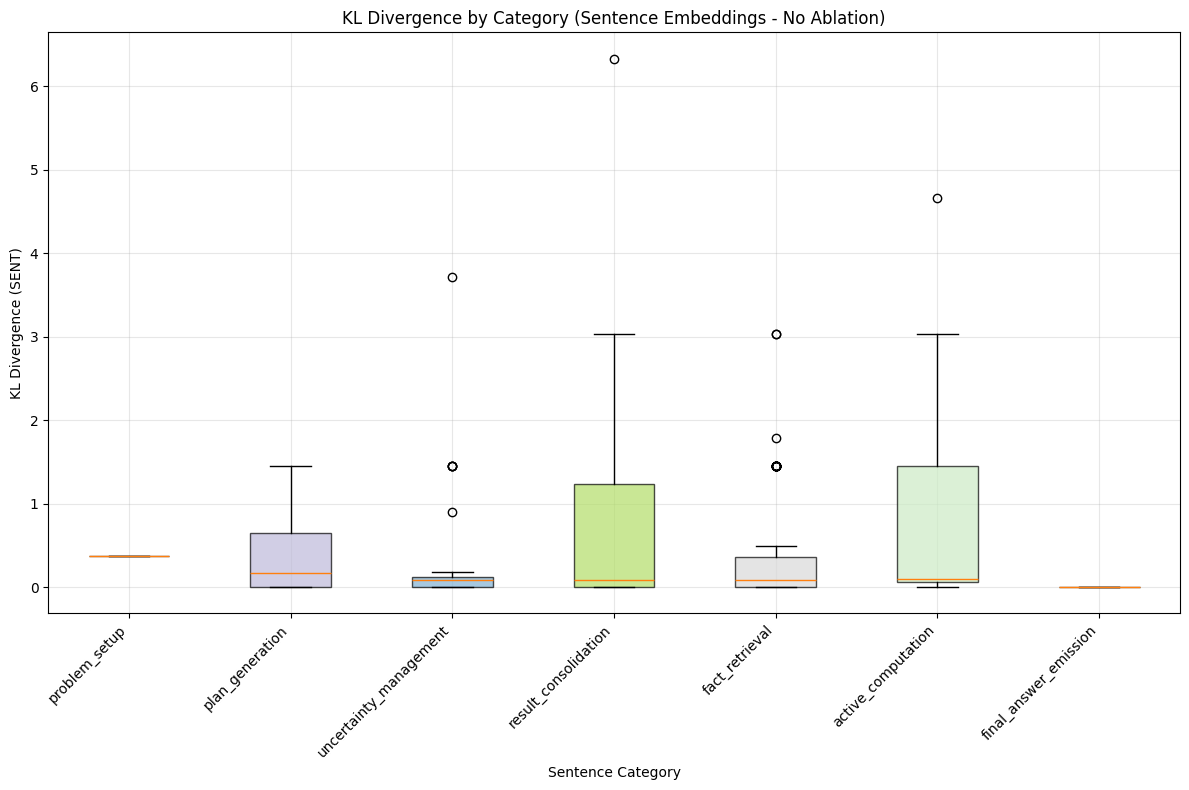


KL Divergence by Category (LLM Embeddings - No Ablation) - Statistics:
--------------------------------------------------
problem_setup: n=1, mean=0.3764, median=0.3764, std=0.0000
plan_generation: n=11, mean=0.2599, median=0.0924, std=0.4128
uncertainty_management: n=29, mean=0.3121, median=0.0541, std=0.6733
result_consolidation: n=15, mean=0.5886, median=0.0870, std=0.8350
fact_retrieval: n=109, mean=0.4188, median=0.0690, std=1.0224
active_computation: n=20, mean=0.8302, median=0.0870, std=1.3755
final_answer_emission: n=1, mean=0.0000, median=0.0000, std=0.0000


/tmp/ipykernel_2175398/1868092253.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(category_kl_values, labels=category_labels, patch_artist=True)


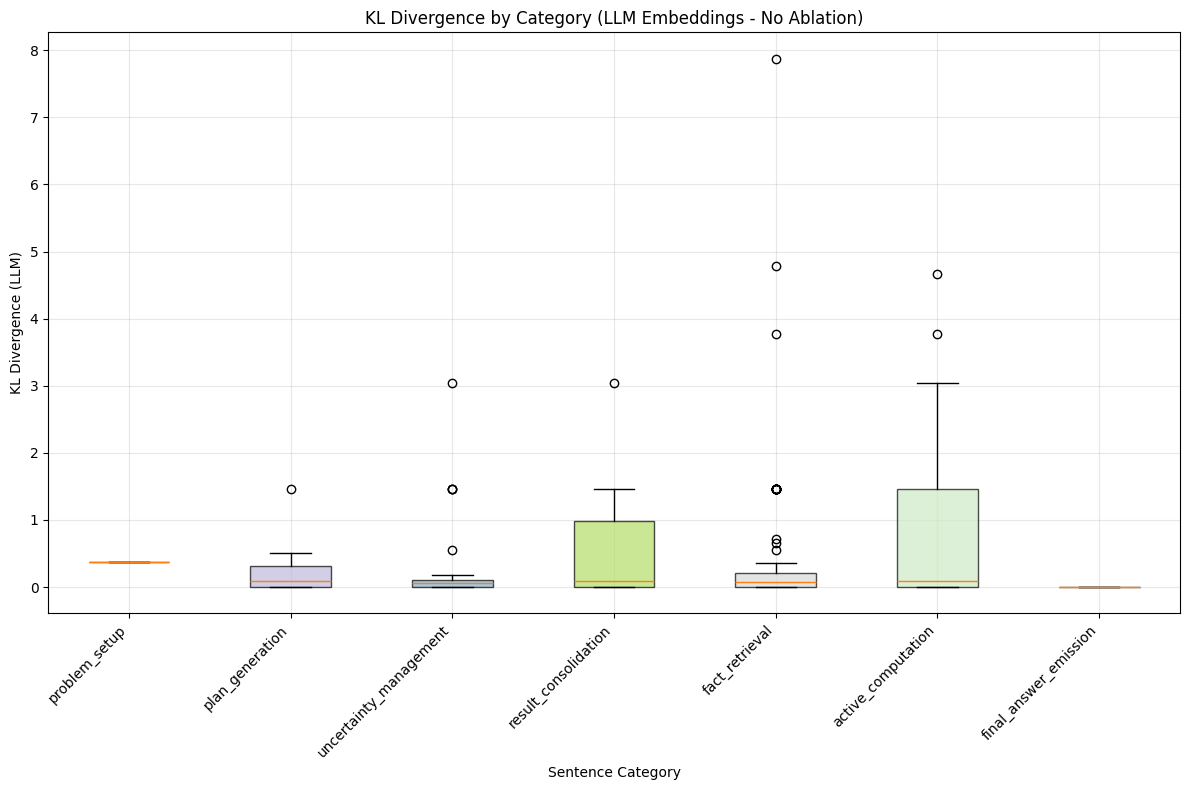

/tmp/ipykernel_2175398/1868092253.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(category_kl_values, labels=category_labels, patch_artist=True)



KL Divergence by Category (Sentence Embeddings - Ablation) - Statistics:
--------------------------------------------------
problem_setup: n=1, mean=0.0646, median=0.0646, std=0.0000
plan_generation: n=11, mean=0.4659, median=0.2683, std=0.5222
uncertainty_management: n=29, mean=0.3528, median=0.0361, std=0.7249
result_consolidation: n=15, mean=0.4551, median=0.0000, std=0.8500
fact_retrieval: n=109, mean=0.4138, median=0.0465, std=0.7844
active_computation: n=20, mean=0.1162, median=0.0148, std=0.3133
final_answer_emission: n=1, mean=0.0000, median=0.0000, std=0.0000


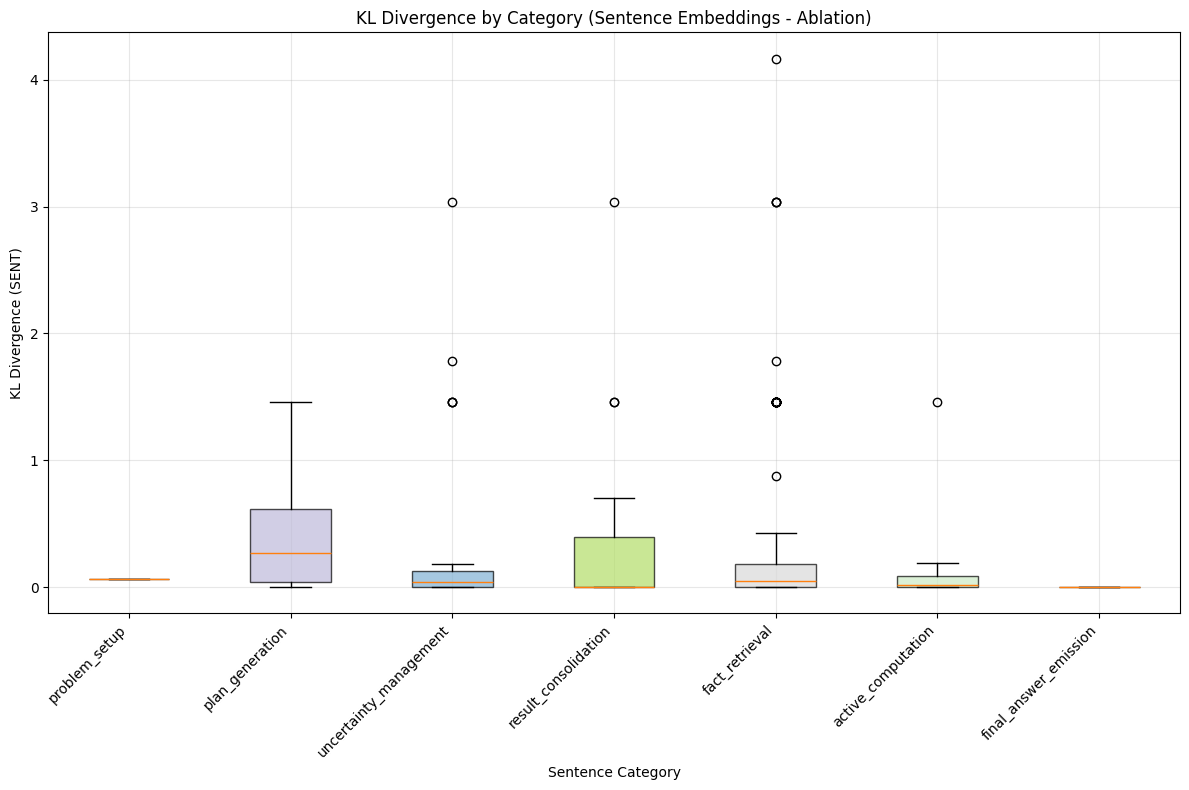

/tmp/ipykernel_2175398/1868092253.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(category_kl_values, labels=category_labels, patch_artist=True)



KL Divergence by Category (LLM Embeddings - Ablation) - Statistics:
--------------------------------------------------
problem_setup: n=1, mean=0.0062, median=0.0062, std=0.0000
plan_generation: n=11, mean=0.6148, median=0.2007, std=0.9073
uncertainty_management: n=29, mean=0.4075, median=0.0541, std=1.0455
result_consolidation: n=15, mean=0.4839, median=0.0000, std=0.9098
fact_retrieval: n=109, mean=0.4034, median=0.0460, std=0.9900
active_computation: n=20, mean=0.1177, median=0.0148, std=0.3129
final_answer_emission: n=1, mean=0.0000, median=0.0000, std=0.0000


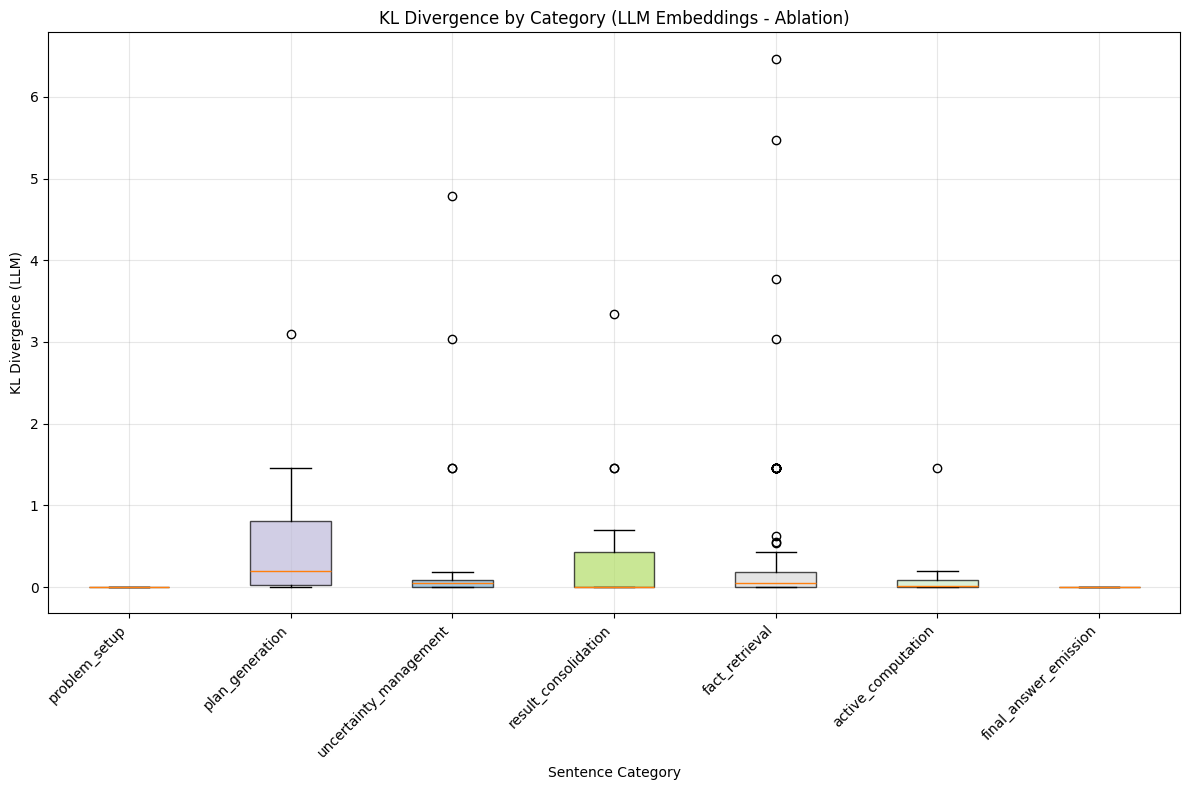

In [97]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_kl_by_category(category_data, title, embedding_type="sent"):
    """
    Create box plots for KL divergence values grouped by sentence category.
    
    Args:
        category_data: Dictionary with categories as keys and lists of results as values
        title: Title for the plot
        embedding_type: "sent" or "llm" to determine which KL divergence to plot
    """
    # Prepare data for plotting
    categories = list(category_data.keys())
    kl_field = f"kl_divergence_{embedding_type}"
    
    # Extract KL divergence values for each category (excluding actual errors)
    category_kl_values = []
    category_labels = []
    
    for category in categories:
        if category:  # Skip empty category names
            # Fixed condition: exclude only if error exists AND is not None
            kl_values = [result[kl_field] for result in category_data[category] 
                        if not (result.get("error") and result["error"] != "Insufficient data for KL divergence calculation")]
            if kl_values:  # Only include categories with data
                category_kl_values.append(kl_values)
                category_labels.append(category)
    
    if not category_kl_values:
        print(f"No data to plot for {title}")
        return
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Create box plot
    box_plot = plt.boxplot(category_kl_values, labels=category_labels, patch_artist=True)
    
    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(category_kl_values)))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.ylabel(f'KL Divergence ({embedding_type.upper()})')
    plt.xlabel('Sentence Category')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Print statistics for each category
    print(f"\n{title} - Statistics:")
    print("-" * 50)
    for i, (category, kl_values) in enumerate(zip(category_labels, category_kl_values)):
        print(f"{category}: n={len(kl_values)}, mean={np.mean(kl_values):.4f}, "
              f"median={np.median(kl_values):.4f}, std={np.std(kl_values):.4f}")
    
    plt.show()

# Create visualizations for each condition
print("Creating KL Divergence visualizations by sentence category...")

# 1. Sentence embeddings - No ablation
visualize_kl_by_category(
    category_sentences_no_ablation, 
    "KL Divergence by Category (Sentence Embeddings - No Ablation)", 
    "sent"
)

# 2. LLM embeddings - No ablation  
visualize_kl_by_category(
    category_llm_no_ablation, 
    "KL Divergence by Category (LLM Embeddings - No Ablation)", 
    "llm"
)

# 3. Sentence embeddings - Ablation
visualize_kl_by_category(
    category_sentences_ablation, 
    "KL Divergence by Category (Sentence Embeddings - Ablation)", 
    "sent"
)

# 4. LLM embeddings - Ablation
visualize_kl_by_category(
    category_llm_ablation, 
    "KL Divergence by Category (LLM Embeddings - Ablation)", 
    "llm"
)

In [98]:
# removes errors
kl_divergences_sentences_no_ablation_filtered = [result["kl_divergence_sent"] for result in kl_results_no_ablation_sent if "error" not in result]
kl_divergences_llm_no_ablation_filtered = [result["kl_divergence_llm"] for result in kl_results_no_ablation_llm if "error" not in result]
kl_divergences_sentences_ablation_filtered = [result["kl_divergence_sent"] for result in kl_divergences_sentences_ablation_result if "error" not in result]
kl_divergences_llm_ablation_filtered = [result["kl_divergence_llm"] for result in kl_divergences_llm_ablation_result if "error" not in result]

/tmp/ipykernel_2175398/3128030090.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kl_divergences_sentences_no_ablation,


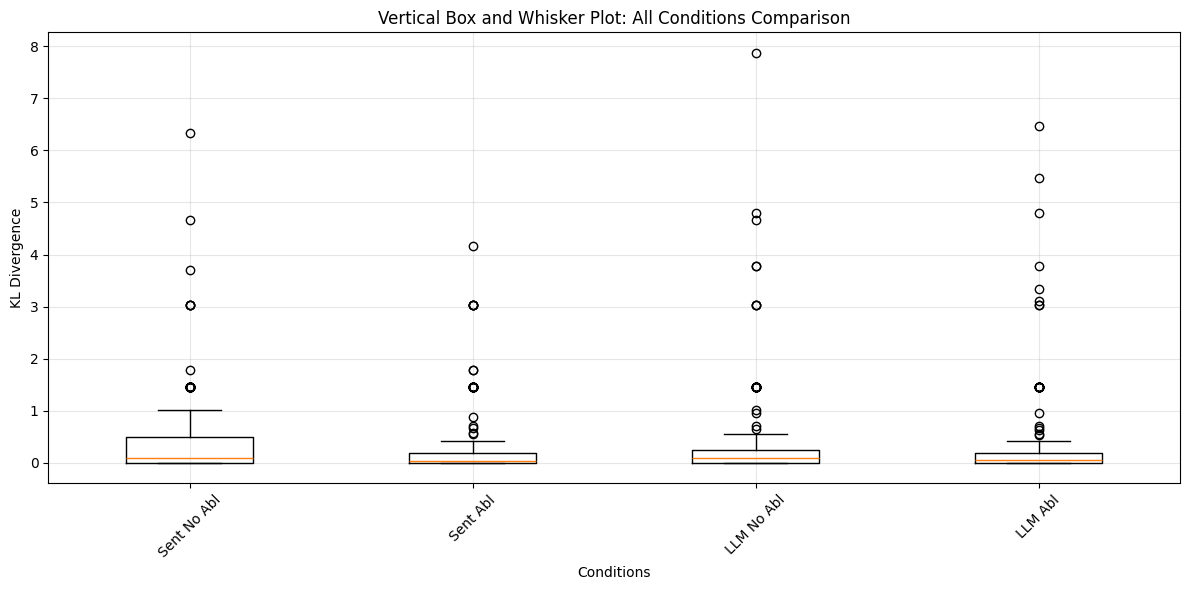

In [99]:
import matplotlib.pyplot as plt

# Create comparative vertical box and whisker plots
plt.figure(figsize=(12, 6))
plt.boxplot([kl_divergences_sentences_no_ablation, 
             kl_divergences_sentences_ablation,
             kl_divergences_llm_no_ablation, 
             kl_divergences_llm_ablation], 
           labels=['Sent No Abl', 'Sent Abl', 'LLM No Abl', 'LLM Abl'], 
           vert=True)
plt.ylabel('KL Divergence')
plt.xlabel('Conditions')
plt.title('Vertical Box and Whisker Plot: All Conditions Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2175398/2403397684.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kl_divergences_sentences_no_ablation_filtered,


(array([1, 2, 3, 4]),
 [Text(1, 0, 'Sent No Abl'),
  Text(2, 0, 'Sent Abl'),
  Text(3, 0, 'LLM No Abl'),
  Text(4, 0, 'LLM Abl')])

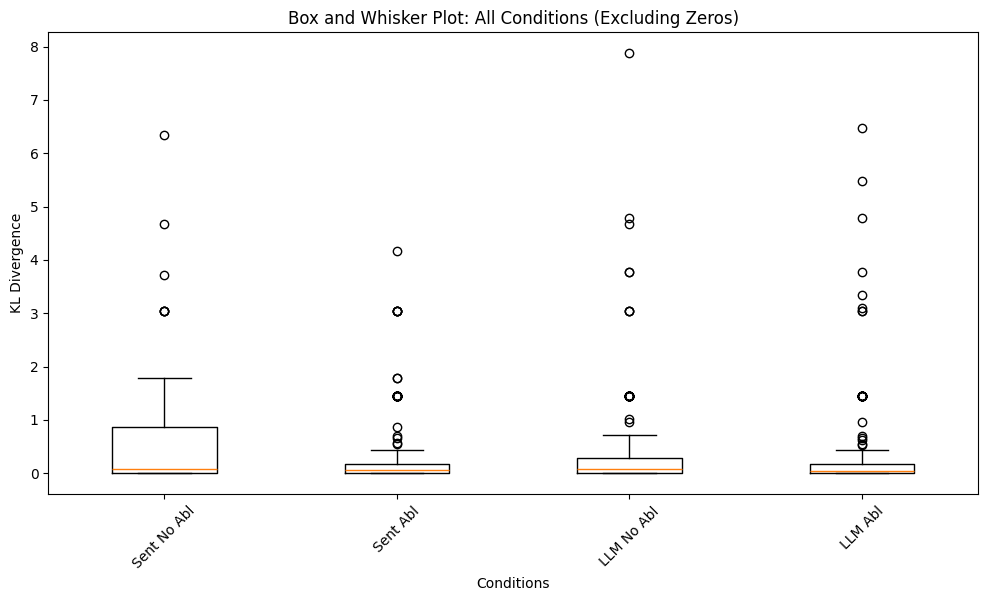

In [100]:
import matplotlib.pyplot as plt

# Create comparative vertical box and whisker plots (excluding zeros)
plt.figure(figsize=(12, 6))
plt.boxplot([kl_divergences_sentences_no_ablation_filtered, 
             kl_divergences_sentences_ablation_filtered,
             kl_divergences_llm_no_ablation_filtered, 
             kl_divergences_llm_ablation_filtered], 
           labels=['Sent No Abl', 'Sent Abl', 'LLM No Abl', 'LLM Abl'], 
           vert=True)
plt.ylabel('KL Divergence')
plt.xlabel('Conditions')
plt.title('Box and Whisker Plot: All Conditions (Excluding Zeros)')
plt.xticks(rotation=45)

In [101]:
import json
from pathlib import Path

# Define the base directory and problem-specific path
base_problem_dir = "math-rollouts/deepseek-r1-distill-llama-8b/temperature_0.6_top_p_0.95/correct_base_solution"
problem_path = Path(base_problem_dir) / "problem_6481" / "chunks_labeled.json"

# Load the JSON file
try:
    with open(problem_path, 'r') as f:
        chunks_labeled = json.load(f)
    
    print(f"Successfully loaded chunks_labeled.json")
    print(f"Data type: {type(chunks_labeled)}")
    
    # Display basic information about the loaded data
    if isinstance(chunks_labeled, list):
        print(f"Number of chunks: {len(chunks_labeled)}")
        if chunks_labeled:
            print(f"First chunk keys: {list(chunks_labeled[0].keys()) if isinstance(chunks_labeled[0], dict) else 'Not a dict'}")
    elif isinstance(chunks_labeled, dict):
        print(f"Top-level keys: {list(chunks_labeled.keys())}")
    
    # Display first few items for inspection
    print(f"\nFirst few items:")
    if isinstance(chunks_labeled, list):
        for i, chunk in enumerate(chunks_labeled[:3]):
            print(f"Chunk {i}: {chunk}")
    else:
        print(chunks_labeled)
        
except FileNotFoundError:
    print(f"File not found: {problem_path}")
    print("Please check the file path and ensure the file exists.")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")
except Exception as e:
    print(f"Error loading file: {e}")

Successfully loaded chunks_labeled.json
Data type: <class 'list'>
Number of chunks: 187
First chunk keys: ['chunk', 'chunk_idx', 'function_tags', 'depends_on', 'accuracy', 'resampling_importance_accuracy', 'resampling_importance_kl', 'counterfactual_importance_accuracy', 'counterfactual_importance_kl', 'forced_importance_accuracy', 'forced_importance_kl', 'different_trajectories_fraction', 'overdeterminedness', 'summary']

First few items:
Chunk 0: {'chunk': 'Okay, so I have this problem about a square with an area of 81 square units.', 'chunk_idx': 0, 'function_tags': ['problem_setup'], 'depends_on': [], 'accuracy': 0.898989898989899, 'resampling_importance_accuracy': -0.09898989898989896, 'resampling_importance_kl': 0.06212096108399145, 'counterfactual_importance_accuracy': 0.042105263157894646, 'counterfactual_importance_kl': 0.08224862729086274, 'forced_importance_accuracy': 0.0, 'forced_importance_kl': 10.757939479731176, 'different_trajectories_fraction': 0.3838383838383838, 'ove

In [102]:
original_kl = [chunk["resampling_importance_kl"] for chunk in chunks_labeled]

In [103]:
original_kl_min = min(original_kl)
original_kl_max = max(original_kl)

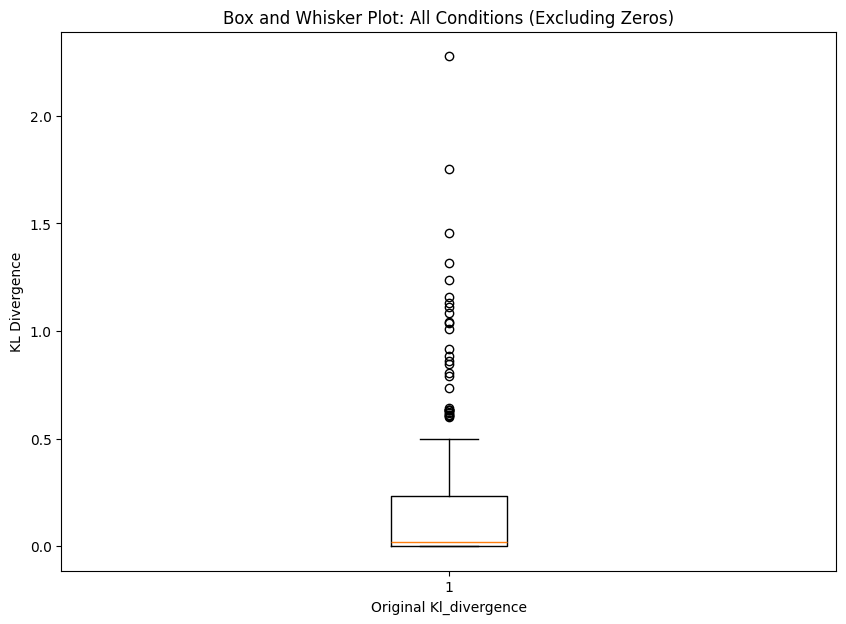

In [104]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(10)

fig = plt.figure(figsize =(10, 7))

plt.boxplot(original_kl)
plt.ylabel('KL Divergence')
plt.xlabel('Original Kl_divergence')
plt.title('Box and Whisker Plot: All Conditions (Excluding Zeros)')
plt.show()

/tmp/ipykernel_2175398/617879071.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kl_divergences_sentences_no_ablation,


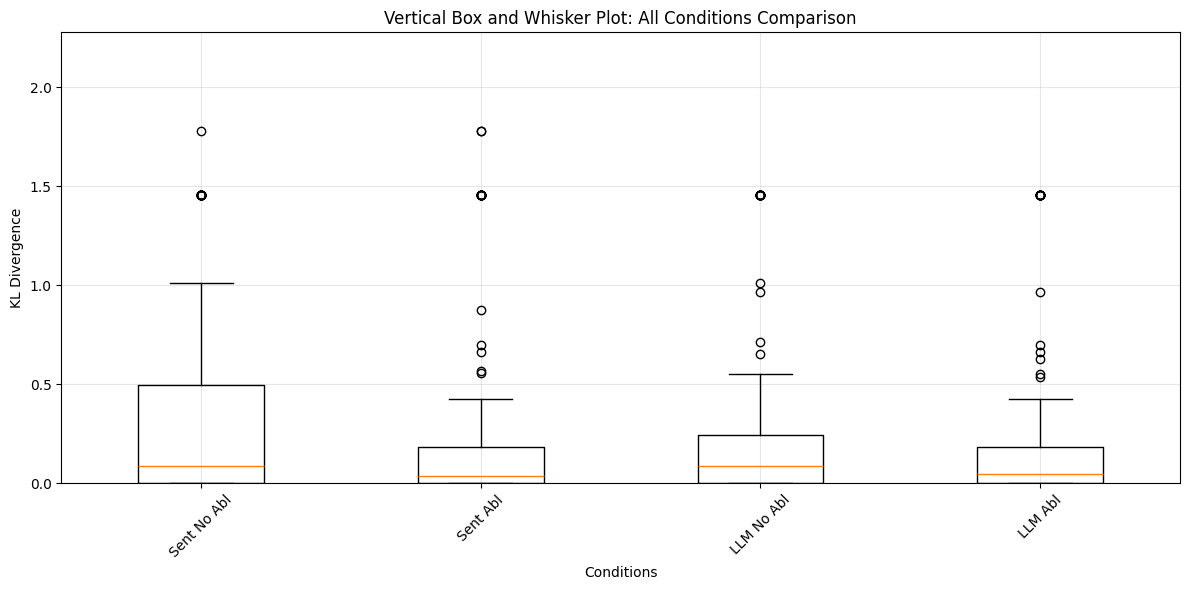

In [105]:
import matplotlib.pyplot as plt

# First, get the range from original_kl
original_kl_min = min(original_kl)
original_kl_max = max(original_kl)

# Create comparative vertical box and whisker plots with same y-range as original
plt.figure(figsize=(12, 6))
plt.boxplot([kl_divergences_sentences_no_ablation, 
             kl_divergences_sentences_ablation,
             kl_divergences_llm_no_ablation, 
             kl_divergences_llm_ablation], 
           labels=['Sent No Abl', 'Sent Abl', 'LLM No Abl', 'LLM Abl'], 
           vert=True)
plt.ylabel('KL Divergence')
plt.xlabel('Conditions')
plt.title('Vertical Box and Whisker Plot: All Conditions Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.ylim(original_kl_min, original_kl_max)  # Set same y-range as original KL
plt.tight_layout()
plt.show()

In [106]:
import numpy as np

# Compute statistics for all conditions
def compute_stats(data, name):
    if len(data) == 0:
        return {"name": name, "mean": 0, "median": 0, "count": 0}
    return {
        "name": name,
        "mean": np.mean(data),
        "median": np.median(data),
        "count": len(data)
    }

# Compute statistics for all conditions
stats_sent_no_abl = compute_stats(kl_divergences_sentences_no_ablation, "Sentence No Ablation")
stats_sent_abl = compute_stats(kl_divergences_sentences_ablation, "Sentence Ablation")
stats_llm_no_abl = compute_stats(kl_divergences_llm_no_ablation, "LLM No Ablation")
stats_llm_abl = compute_stats(kl_divergences_llm_ablation, "LLM Ablation")

# Also compute for filtered (non-zero) data
stats_sent_no_abl_filt = compute_stats(kl_divergences_sentences_no_ablation_filtered, "Sentence No Ablation (Filtered)")
stats_sent_abl_filt = compute_stats(kl_divergences_sentences_ablation_filtered, "Sentence Ablation (Filtered)")
stats_llm_no_abl_filt = compute_stats(kl_divergences_llm_no_ablation_filtered, "LLM No Ablation (Filtered)")
stats_llm_abl_filt = compute_stats(kl_divergences_llm_ablation_filtered, "LLM Ablation (Filtered)")

# Print results
print("=== STATISTICS COMPARISON ===\n")

print("ALL DATA (including zeros):")
for stats in [stats_sent_no_abl, stats_sent_abl, stats_llm_no_abl, stats_llm_abl]:
    print(f"{stats['name']:25} | Mean: {stats['mean']:.4f} | Median: {stats['median']:.4f} | Count: {stats['count']}")

print("\nFILTERED DATA (excluding zeros):")
for stats in [stats_sent_no_abl_filt, stats_sent_abl_filt, stats_llm_no_abl_filt, stats_llm_abl_filt]:
    print(f"{stats['name']:30} | Mean: {stats['mean']:.4f} | Median: {stats['median']:.4f} | Count: {stats['count']}")

print("\n=== COMPARISONS ===")

print("\nSENTENCE EMBEDDINGS:")
print(f"No Ablation vs Ablation (Mean): {stats_sent_no_abl['mean']:.4f} vs {stats_sent_abl['mean']:.4f} | Diff: {stats_sent_no_abl['mean'] - stats_sent_abl['mean']:.4f}")
print(f"No Ablation vs Ablation (Median): {stats_sent_no_abl['median']:.4f} vs {stats_sent_abl['median']:.4f} | Diff: {stats_sent_no_abl['median'] - stats_sent_abl['median']:.4f}")

print("\nLLM EMBEDDINGS:")
print(f"No Ablation vs Ablation (Mean): {stats_llm_no_abl['mean']:.4f} vs {stats_llm_abl['mean']:.4f} | Diff: {stats_llm_no_abl['mean'] - stats_llm_abl['mean']:.4f}")
print(f"No Ablation vs Ablation (Median): {stats_llm_no_abl['median']:.4f} vs {stats_llm_abl['median']:.4f} | Diff: {stats_llm_no_abl['median'] - stats_llm_abl['median']:.4f}")

print("\nFILTERED COMPARISONS:")
print("\nSENTENCE EMBEDDINGS (Filtered):")
print(f"No Ablation vs Ablation (Mean): {stats_sent_no_abl_filt['mean']:.4f} vs {stats_sent_abl_filt['mean']:.4f} | Diff: {stats_sent_no_abl_filt['mean'] - stats_sent_abl_filt['mean']:.4f}")
print(f"No Ablation vs Ablation (Median): {stats_sent_no_abl_filt['median']:.4f} vs {stats_sent_abl_filt['median']:.4f} | Diff: {stats_sent_no_abl_filt['median'] - stats_sent_abl_filt['median']:.4f}")

print("\nLLM EMBEDDINGS (Filtered):")
print(f"No Ablation vs Ablation (Mean): {stats_llm_no_abl_filt['mean']:.4f} vs {stats_llm_abl_filt['mean']:.4f} | Diff: {stats_llm_no_abl_filt['mean'] - stats_llm_abl_filt['mean']:.4f}")
print(f"No Ablation vs Ablation (Median): {stats_llm_no_abl_filt['median']:.4f} vs {stats_llm_abl_filt['median']:.4f} | Diff: {stats_llm_no_abl_filt['median'] - stats_llm_abl_filt['median']:.4f}")

=== STATISTICS COMPARISON ===

ALL DATA (including zeros):
Sentence No Ablation      | Mean: 0.4895 | Median: 0.0870 | Count: 186
Sentence Ablation         | Mean: 0.3746 | Median: 0.0386 | Count: 186
LLM No Ablation           | Mean: 0.4482 | Median: 0.0870 | Count: 186
LLM Ablation              | Mean: 0.3880 | Median: 0.0452 | Count: 186

FILTERED DATA (excluding zeros):
Sentence No Ablation (Filtered) | Mean: 0.5059 | Median: 0.0870 | Count: 180
Sentence Ablation (Filtered)   | Mean: 0.3892 | Median: 0.0541 | Count: 179
LLM No Ablation (Filtered)     | Mean: 0.4792 | Median: 0.0870 | Count: 174
LLM Ablation (Filtered)        | Mean: 0.4148 | Median: 0.0500 | Count: 174

=== COMPARISONS ===

SENTENCE EMBEDDINGS:
No Ablation vs Ablation (Mean): 0.4895 vs 0.3746 | Diff: 0.1149
No Ablation vs Ablation (Median): 0.0870 vs 0.0386 | Diff: 0.0484

LLM EMBEDDINGS:
No Ablation vs Ablation (Mean): 0.4482 vs 0.3880 | Diff: 0.0602
No Ablation vs Ablation (Median): 0.0870 vs 0.0452 | Diff: 0.041

/tmp/ipykernel_2175398/2074236464.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([kl_divergences_sentences_no_ablation_filtered,


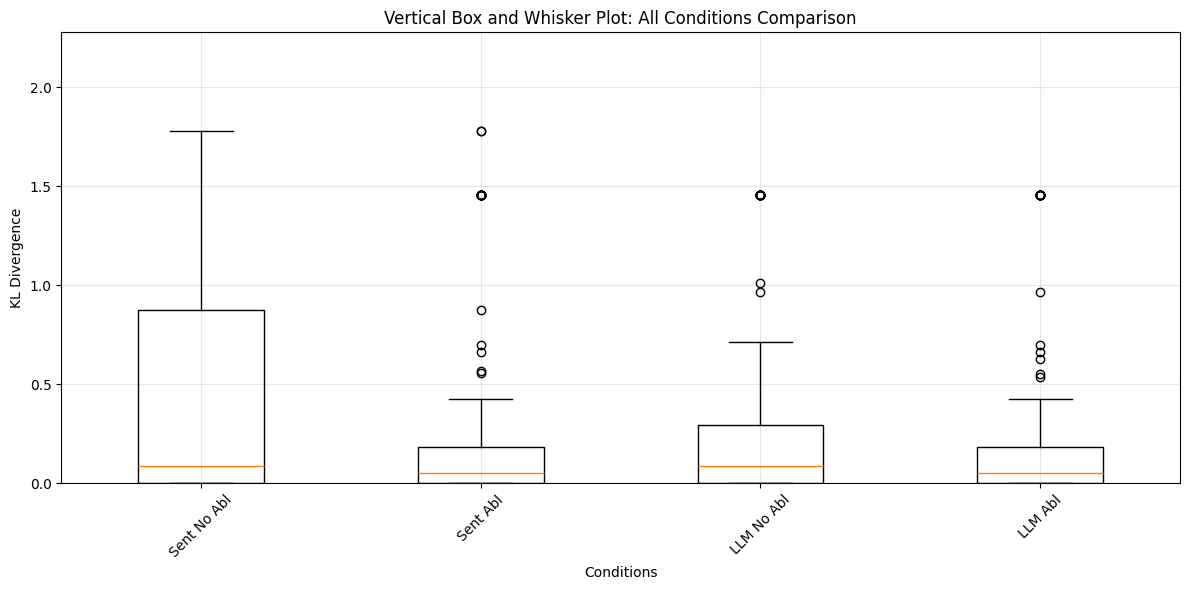

In [107]:
import matplotlib.pyplot as plt

# First, get the range from original_kl
original_kl_min = min(original_kl)
original_kl_max = max(original_kl)

# Create comparative vertical box and whisker plots with same y-range as original
plt.figure(figsize=(12, 6))
plt.boxplot([kl_divergences_sentences_no_ablation_filtered, 
             kl_divergences_sentences_ablation_filtered,
             kl_divergences_llm_no_ablation_filtered, 
             kl_divergences_llm_ablation_filtered], 
           labels=['Sent No Abl', 'Sent Abl', 'LLM No Abl', 'LLM Abl'], 
           vert=True)
plt.ylabel('KL Divergence')
plt.xlabel('Conditions')
plt.title('Vertical Box and Whisker Plot: All Conditions Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.ylim(original_kl_min, original_kl_max)  # Set same y-range as original KL
plt.tight_layout()
plt.show()

In [108]:
#important functions in thought anchors
# def process_chunk_importance
# def calculate_counterfactual_importance_accuracy(chunk_idx, chunk_info, chunk_embedding_cache, chunk_accuracies, args):
    
# def calculate_kl_divergence(chunk_sols1, chunk_sols2, laplace_smooth=False, use_prob_true=True):
# def calculate_counterfactual_importance_kl(chunk_idx, chunk_info, chunk_embedding_cache, chunk_accuracies, chunk_answers, args):

Filtering cosine similarity data (first 12 rollouts per sentence)...
Creating Cosine Similarity visualizations by sentence category (first 12 rollouts)...


Cosine Similarity by Category (Sentence Embeddings - No Ablation, First 12 Rollouts) - Statistics:
----------------------------------------------------------------------
problem_setup: 1 sentences, 12 rollouts, mean=0.8675, median=0.9433, std=0.2304
plan_generation: 11 sentences, 132 rollouts, mean=0.5019, median=0.5877, std=0.3057
uncertainty_management: 29 sentences, 348 rollouts, mean=0.3184, median=0.2423, std=0.2329
result_consolidation: 15 sentences, 180 rollouts, mean=0.3138, median=0.2468, std=0.1894
fact_retrieval: 109 sentences, 1308 rollouts, mean=0.3811, median=0.2833, std=0.2634
active_computation: 20 sentences, 240 rollouts, mean=0.4687, median=0.3305, std=0.3067
final_answer_emission: 2 sentences, 24 rollouts, mean=0.3404, median=0.3263, std=0.0241


/tmp/ipykernel_2175398/1811773108.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(category_cos_sim_values, labels=category_labels, patch_artist=True)


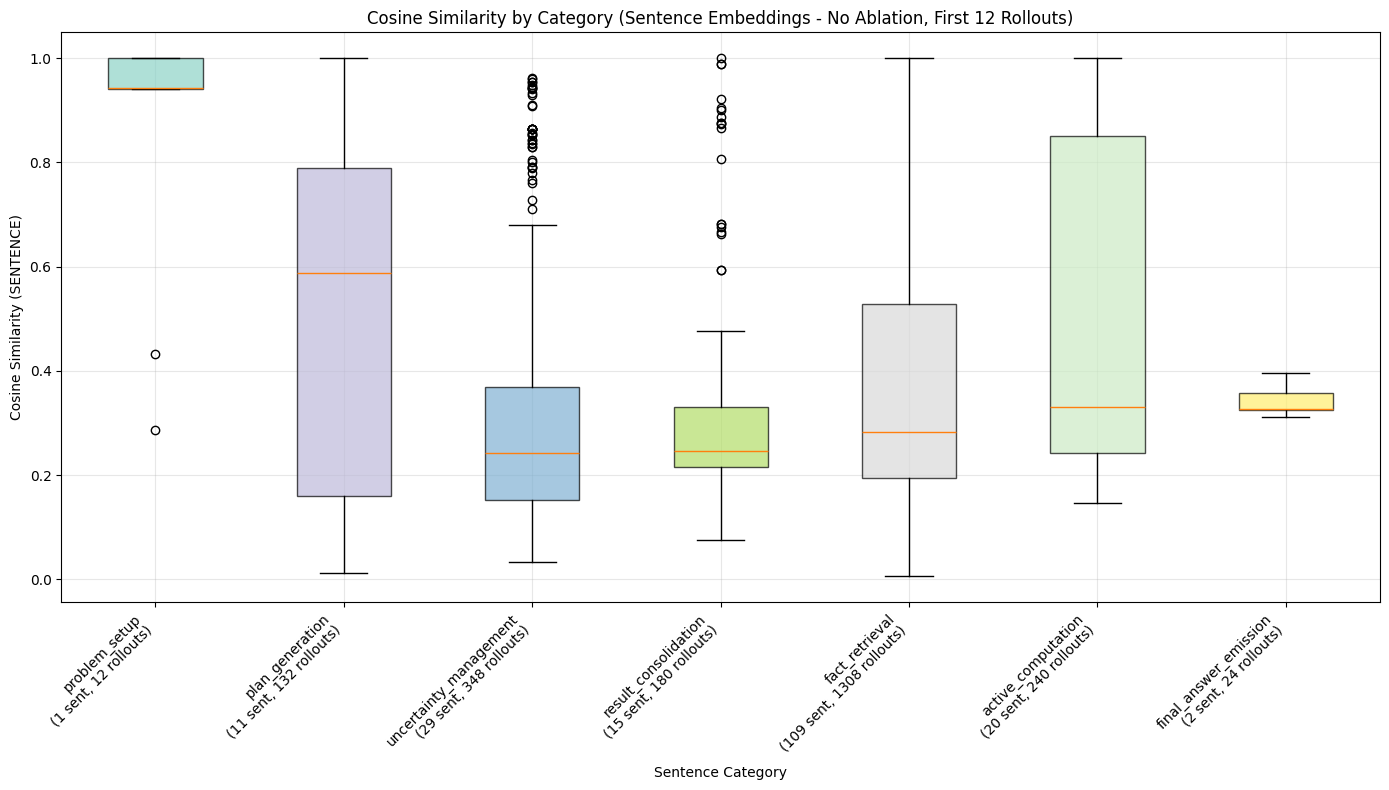



Cosine Similarity by Category (LLM Embeddings - No Ablation, First 12 Rollouts) - Statistics:
----------------------------------------------------------------------
problem_setup: 1 sentences, 12 rollouts, mean=0.9274, median=0.9811, std=0.1384
plan_generation: 11 sentences, 132 rollouts, mean=0.8031, median=0.7927, std=0.1020
uncertainty_management: 29 sentences, 348 rollouts, mean=0.7515, median=0.7490, std=0.0766
result_consolidation: 15 sentences, 180 rollouts, mean=0.7646, median=0.7582, std=0.0690
fact_retrieval: 109 sentences, 1308 rollouts, mean=0.7517, median=0.7501, std=0.1130
active_computation: 20 sentences, 240 rollouts, mean=0.7865, median=0.7519, std=0.1091
final_answer_emission: 2 sentences, 24 rollouts, mean=0.5666, median=0.5762, std=0.1549


/tmp/ipykernel_2175398/1811773108.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(category_cos_sim_values, labels=category_labels, patch_artist=True)


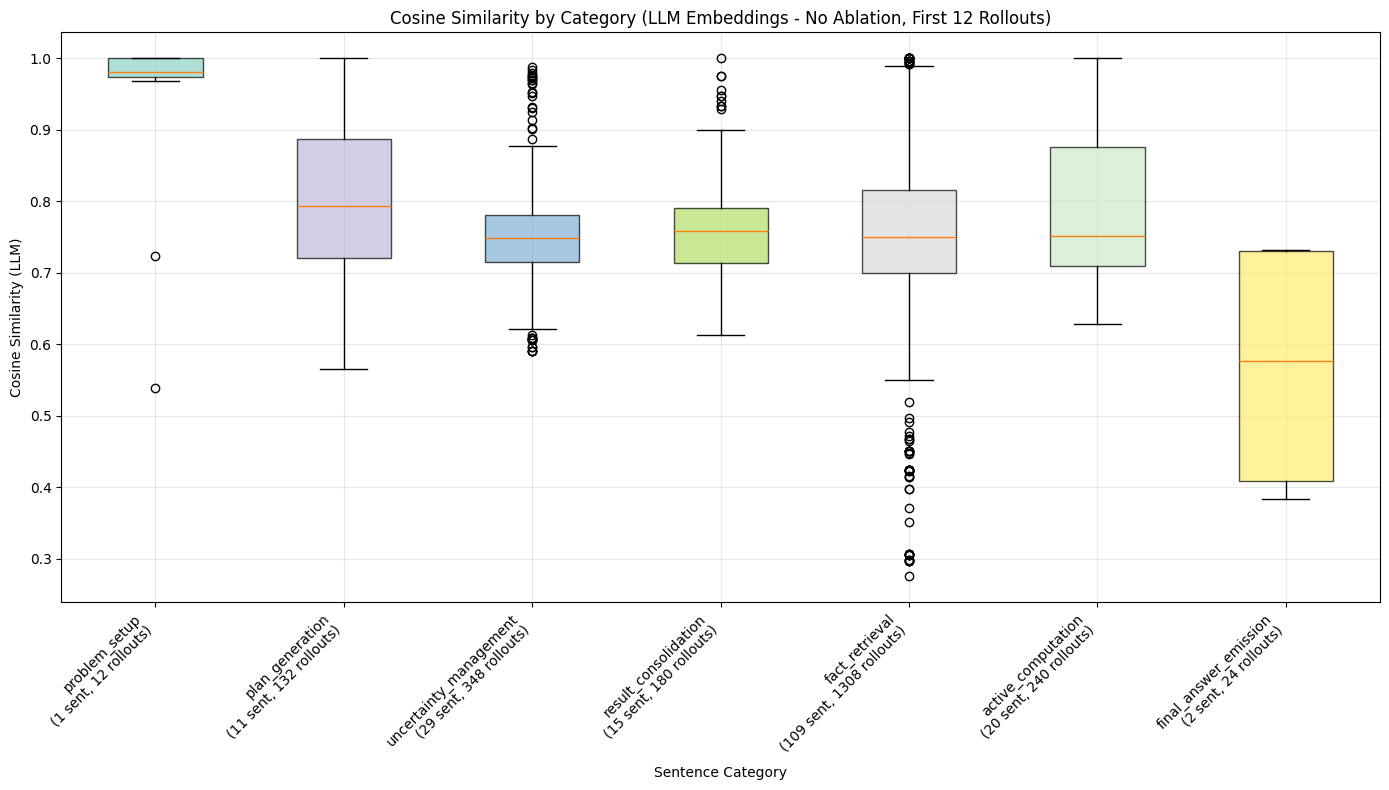



Cosine Similarity by Category (Sentence Embeddings - Ablation, First 12 Rollouts) - Statistics:
----------------------------------------------------------------------
problem_setup: 1 sentences, 12 rollouts, mean=0.7199, median=0.8932, std=0.2717
plan_generation: 11 sentences, 132 rollouts, mean=0.4783, median=0.5438, std=0.3074
uncertainty_management: 29 sentences, 348 rollouts, mean=0.3105, median=0.2298, std=0.2356
result_consolidation: 15 sentences, 180 rollouts, mean=0.3026, median=0.2446, std=0.1782
fact_retrieval: 109 sentences, 1308 rollouts, mean=0.3741, median=0.2823, std=0.2568
active_computation: 20 sentences, 240 rollouts, mean=0.4677, median=0.3159, std=0.3092
final_answer_emission: 2 sentences, 24 rollouts, mean=0.3477, median=0.3556, std=0.0243


/tmp/ipykernel_2175398/1811773108.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(category_cos_sim_values, labels=category_labels, patch_artist=True)


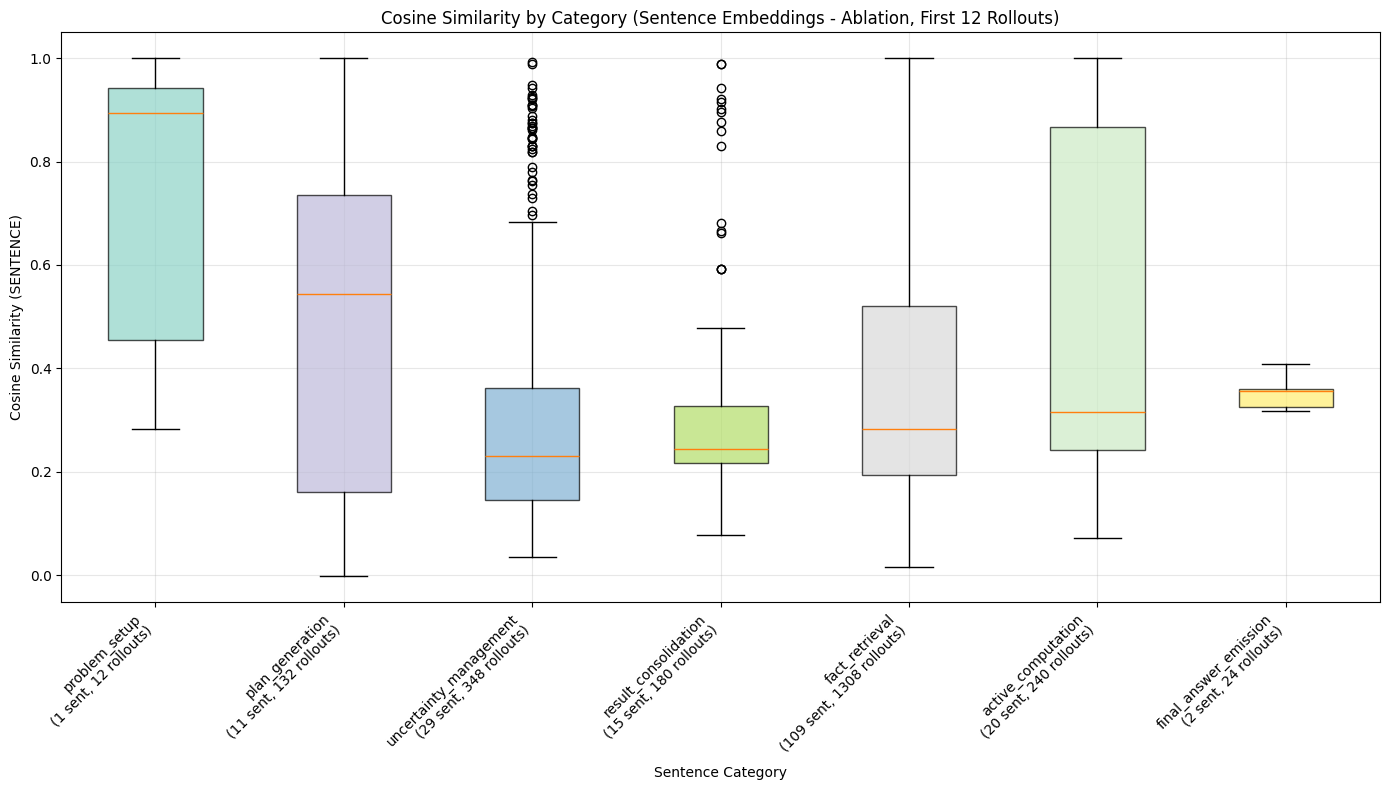



Cosine Similarity by Category (LLM Embeddings - Ablation, First 12 Rollouts) - Statistics:
----------------------------------------------------------------------
problem_setup: 1 sentences, 12 rollouts, mean=0.8300, median=0.8557, std=0.1634
plan_generation: 11 sentences, 132 rollouts, mean=0.7996, median=0.7931, std=0.1002
uncertainty_management: 29 sentences, 348 rollouts, mean=0.7485, median=0.7492, std=0.0799
result_consolidation: 15 sentences, 180 rollouts, mean=0.7625, median=0.7616, std=0.0641
fact_retrieval: 109 sentences, 1308 rollouts, mean=0.7525, median=0.7530, std=0.1086
active_computation: 20 sentences, 240 rollouts, mean=0.7864, median=0.7614, std=0.1022
final_answer_emission: 2 sentences, 24 rollouts, mean=0.5613, median=0.5671, std=0.1568


/tmp/ipykernel_2175398/1811773108.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(category_cos_sim_values, labels=category_labels, patch_artist=True)


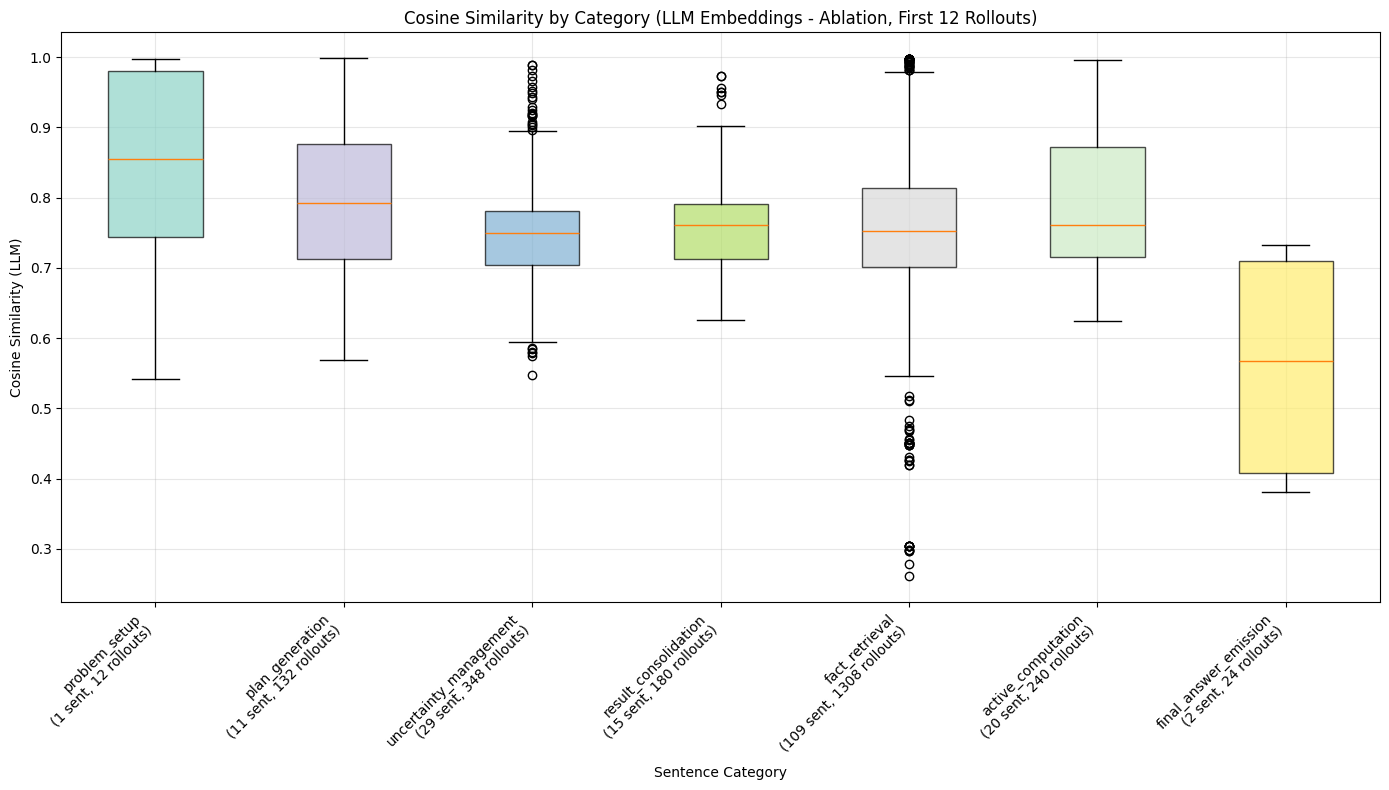

([[0.9804867506027222,
   0.9478656053543091,
   0.9662364721298218,
   0.7465230822563171,
   0.5518922805786133,
   0.5419816970825195,
   0.9802509546279907,
   0.7440460920333862,
   0.7423157095909119,
   0.9975054264068604,
   0.9975054264068604,
   0.7636196613311768],
  [0.7453771233558655,
   0.7093031406402588,
   0.7571513056755066,
   0.7124469876289368,
   0.7124189138412476,
   0.7093031406402588,
   0.6631963849067688,
   0.9496887922286987,
   0.6617276668548584,
   0.6527635455131531,
   0.7585985660552979,
   0.9978570938110352,
   0.7055952548980713,
   0.8868659734725952,
   0.9985873699188232,
   0.9985873699188232,
   0.8868659734725952,
   0.7055952548980713,
   0.9986124038696289,
   0.7921201586723328,
   0.8754386305809021,
   0.9986124038696289,
   0.9986124038696289,
   0.8864471316337585,
   0.8024849891662598,
   0.8807885646820068,
   0.8886311054229736,
   0.6795244812965393,
   0.8615163564682007,
   0.8861649632453918,
   0.9010034799575806,
   0.83905

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def filter_by_category_cos_sim_limited(rollout_results, limit=12):
    """
    Filter rollout results by sentence category and extract cosine similarity data,
    limiting to first N rollouts per sentence.
    
    Args:
        rollout_results: List of rollout result dictionaries
        limit: Number of rollouts to consider per sentence (default 12)
    
    Returns:
        Dictionary with categories as keys and lists of results as values
    """
    filtered_results = defaultdict(list)
    
    for result in rollout_results:
        # Skip error results
        if "error" in result:
            continue
            
        category = result.get("function_tags", [""])[0] if result.get("function_tags") else ""
        
        # Limit cosine similarities to first N rollouts
        cos_sims_llm_limited = result["cos_sims_llm"][:limit]
        cos_sims_sentence_limited = result["cos_sims_sentence"][:limit]
        
        filtered_result = {
            "sentence_idx": result["sentence_idx"],
            "sentence_category": category,
            "cos_sims_llm": cos_sims_llm_limited,
            "cos_sims_sentence": cos_sims_sentence_limited,
            "sentence_text": result.get("sentence_text", ""),
            "num_rollouts_used": len(cos_sims_llm_limited)
        }
        filtered_results[category].append(filtered_result)
    
    return filtered_results

def visualize_cos_sim_by_category_limited(category_data, title, embedding_type="sentence"):
    """
    Create box plots for cosine similarity values grouped by sentence category.
    
    Args:
        category_data: Dictionary with categories as keys and lists of results as values
        title: Title for the plot
        embedding_type: "sentence" or "llm" to determine which cosine similarity to plot
    """
    # Prepare data for plotting
    categories = list(category_data.keys())
    cos_sim_field = f"cos_sims_{embedding_type if embedding_type == 'llm' else 'sentence'}"
    
    # Extract cosine similarity values for each category
    category_cos_sim_values = []
    category_labels = []
    category_counts = []
    
    for category in categories:
        if category:  # Skip empty category names
            # Flatten all cosine similarity values for this category
            cos_sim_values = []
            total_sentences = 0
            total_rollouts = 0
            
            for result in category_data[category]:
                cos_sim_values.extend(result[cos_sim_field])
                total_sentences += 1
                total_rollouts += result["num_rollouts_used"]
            
            if cos_sim_values:  # Only include categories with data
                category_cos_sim_values.append(cos_sim_values)
                category_labels.append(f"{category}\n({total_sentences} sent, {total_rollouts} rollouts)")
                category_counts.append((total_sentences, total_rollouts))
    
    if not category_cos_sim_values:
        print(f"No data to plot for {title}")
        return
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Create box plot
    box_plot = plt.boxplot(category_cos_sim_values, labels=category_labels, patch_artist=True)
    
    # Color the boxes
    colors = plt.cm.Set3(np.linspace(0, 1, len(category_cos_sim_values)))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.ylabel(f'Cosine Similarity ({embedding_type.upper()})')
    plt.xlabel('Sentence Category')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Print statistics for each category
    print(f"\n{title} - Statistics:")
    print("-" * 70)
    for i, (category_label, cos_sim_values) in enumerate(zip(category_labels, category_cos_sim_values)):
        category_name = category_label.split('\n')[0]
        sentences, rollouts = category_counts[i]
        print(f"{category_name}: {sentences} sentences, {rollouts} rollouts, "
              f"mean={np.mean(cos_sim_values):.4f}, "
              f"median={np.median(cos_sim_values):.4f}, "
              f"std={np.std(cos_sim_values):.4f}")
    
    plt.show()
    return category_cos_sim_values, category_labels

# Filter the rollout data by category for cosine similarities (limited to first 12)
print("Filtering cosine similarity data (first 12 rollouts per sentence)...")
category_cos_sim_no_ablation_12 = filter_by_category_cos_sim_limited(sentence_rollouts_no_ablation, limit=12)
category_cos_sim_ablation_12 = filter_by_category_cos_sim_limited(sentence_rollouts_ablation, limit=12)

print("Creating Cosine Similarity visualizations by sentence category (first 12 rollouts)...")

# 1. Sentence embeddings - No ablation
print("\n" + "="*80)
visualize_cos_sim_by_category_limited(
    category_cos_sim_no_ablation_12, 
    "Cosine Similarity by Category (Sentence Embeddings - No Ablation, First 12 Rollouts)", 
    "sentence"
)

# 2. LLM embeddings - No ablation  
print("\n" + "="*80)
visualize_cos_sim_by_category_limited(
    category_cos_sim_no_ablation_12, 
    "Cosine Similarity by Category (LLM Embeddings - No Ablation, First 12 Rollouts)", 
    "llm"
)

# 3. Sentence embeddings - Ablation
print("\n" + "="*80)
visualize_cos_sim_by_category_limited(
    category_cos_sim_ablation_12, 
    "Cosine Similarity by Category (Sentence Embeddings - Ablation, First 12 Rollouts)", 
    "sentence"
)

# 4. LLM embeddings - Ablation
print("\n" + "="*80)
visualize_cos_sim_by_category_limited(
    category_cos_sim_ablation_12, 
    "Cosine Similarity by Category (LLM Embeddings - Ablation, First 12 Rollouts)", 
    "llm"
)

In [110]:
import json
from pathlib import Path

ablation_path = Path("random_rollout_results_ablation") / "problem_6481" / "sentence_multi_head_ablation_rollouts.json"
with open(ablation_path, 'r') as f:
    sentence_rollouts_random_ablation = json.load(f)

print(f"Loaded {len(sentence_rollouts_random_ablation)} ablation sentence results (random ablation)")

Loaded 187 ablation sentence results (random ablation)


In [111]:
kl_results_random_ablation_sent = process_rollouts_kl_counterfactual_importance(sentence_rollouts_random_ablation, sent=True)
kl_results_random_ablation_llm = process_rollouts_kl_counterfactual_importance(sentence_rollouts_random_ablation, sent=False)

In [112]:
category_sentences_random_ablation = filter_by_category(kl_results_random_ablation_sent)
category_llm_random_ablation = filter_by_category(kl_results_random_ablation_llm)

/tmp/ipykernel_2175398/1868092253.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(category_kl_values, labels=category_labels, patch_artist=True)



KL Divergence by Category (Sentence Embeddings - Random Ablation) - Statistics:
--------------------------------------------------
problem_setup: n=1, mean=0.1438, median=0.1438, std=0.0000
plan_generation: n=11, mean=0.0943, median=0.0201, std=0.1067
uncertainty_management: n=27, mean=0.8847, median=0.0000, std=1.9396
result_consolidation: n=17, mean=0.0117, median=0.0000, std=0.0428
fact_retrieval: n=107, mean=0.6229, median=0.0000, std=1.4543
active_computation: n=20, mean=0.4954, median=0.0000, std=1.0219
final_answer_emission: n=3, mean=1.0017, median=0.0870, std=1.3556


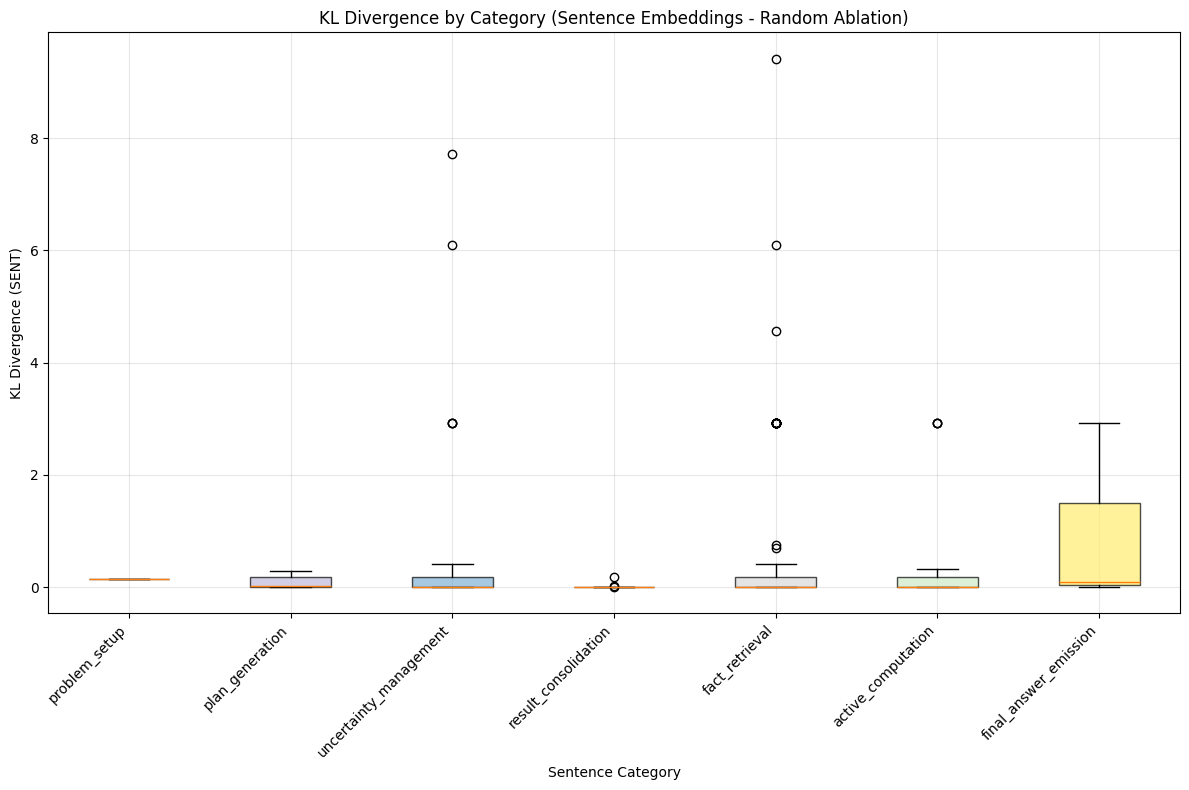

/tmp/ipykernel_2175398/1868092253.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(category_kl_values, labels=category_labels, patch_artist=True)



KL Divergence by Category (LLM Embeddings - Random Ablation) - Statistics:
--------------------------------------------------
problem_setup: n=1, mean=0.3564, median=0.3564, std=0.0000
plan_generation: n=11, mean=0.2623, median=0.1100, std=0.4820
uncertainty_management: n=27, mean=0.8371, median=0.0000, std=1.7671
result_consolidation: n=17, mean=0.0181, median=0.0000, std=0.0485
fact_retrieval: n=107, mean=0.5553, median=0.0000, std=1.5359
active_computation: n=20, mean=0.4901, median=0.0000, std=1.0241
final_answer_emission: n=3, mean=1.0017, median=0.0870, std=1.3556


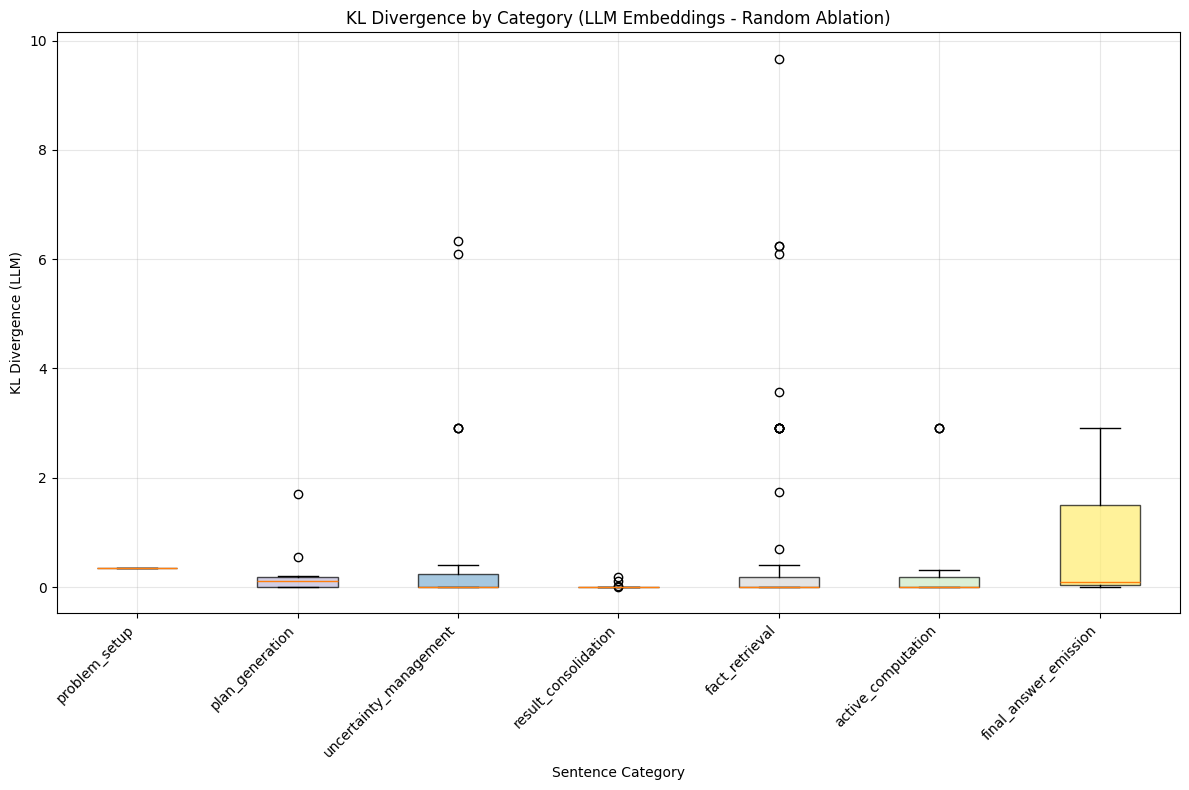

In [113]:
visualize_kl_by_category(
    category_sentences_random_ablation, 
    "KL Divergence by Category (Sentence Embeddings - Random Ablation)", 
    "sent"
)

visualize_kl_by_category(
    category_llm_random_ablation, 
    "KL Divergence by Category (LLM Embeddings - Random Ablation)", 
    "llm"
)

In [114]:
import json
from pathlib import Path

# Load results for a specific problem
problem_id = "problem_6481"  # Your processed problem
results_dir = Path("rollout_results_no_ablation") / problem_id

# Load the sentence rollouts
with open(results_dir / "sentence_rollouts.json", 'r') as f:
    sentence_rollouts_no_ablation = json.load(f)

print(f"Loaded {len(sentence_rollouts_no_ablation)} sentence results")

Loaded 187 sentence results


In [115]:
import json
from pathlib import Path

# Load results for a specific problem
problem_id = "problem_6481"  # Your processed problem
results_dir = Path("rollout_results_no_ablation") / problem_id

# Load the sentence rollouts
with open(results_dir / "sentence_rollouts.json", 'r') as f:
    sentence_rollouts_no_ablation = json.load(f)

print(f"Loaded {len(sentence_rollouts_no_ablation)} sentence results")

Loaded 187 sentence results


In [116]:
import json
from pathlib import Path

# Load results for a specific problem
problem_id = "problem_6481"  # Your processed problem
results_dir = Path("72_rollout_results_ablation") / problem_id

# Load the sentence rollouts
with open(results_dir / "sentence_multi_head_ablation_rollouts.json", 'r') as f:
    sentence_rollouts_ablation_72 = json.load(f)

print(f"Loaded {len(sentence_rollouts_ablation_72)} sentence results")

Loaded 187 sentence results


In [117]:
def process_rollouts_accuracy(rollouts, sent=True, correct_metric='rollout_answer_correct_check'):
  # check_valid_list(rollouts) # can be used to check if the rollouts are in order from 0 - x and no duplicates
  correct = 0
  total = 0
  for i in range(len(rollouts)-1):
        rollout = rollouts[i]
        #(rollout_answer_correct, cos_sims, similarity_threshold=0.8, next_rollout_answer_correct=[]):
        answer_correct = rollout[correct_metric][:12] # only first 12 rollouts
        
        correct += sum(answer_correct)
        total += len(answer_correct)

  return correct / total if total > 0 else 0


In [118]:
ablation_accuracy_sent_72 = process_rollouts_accuracy(sentence_rollouts_ablation_72, sent=True)
no_ablation_accuracy_sent = process_rollouts_accuracy(sentence_rollouts_no_ablation, sent=True)
ablation_accuracy_sent = process_rollouts_accuracy(sentence_rollouts_ablation, sent=True)


print(f"72 Ablation accuracy: {ablation_accuracy_sent_72:.4f}")
print(f"No ablation accuracy: {no_ablation_accuracy_sent:.4f}")
print(f"Ablation accuracy: {ablation_accuracy_sent:.4f}")


72 Ablation accuracy: 0.9140
No ablation accuracy: 0.9149
Ablation accuracy: 0.9306


In [119]:
from collections import Counter
def print_categories_in_range(results, idx_start, idx_end):
    """
    Print sentence categories and their counts for sentence_idx in [idx_start, idx_end].
    """
    filtered = [r for r in results if idx_start <= r.get("sentence_idx", -1) <= idx_end and "error" not in r]
    cats = [r.get("sentence_category", "") for r in filtered]
    idx_cat = [(r.get("sentence_idx", -1), r.get("sentence_category", "")) for r in filtered]
    print(f"\nSentence idx range {idx_start}-{idx_end}:")
    print("idx | category")
    for idx, cat in idx_cat:
        print(f"{idx:3d} | {cat}")
    print("\nCategory counts:", Counter(cats).most_common())

# Example usage:
# print_categories_in_range(kl_results_no_ablation_sent, 10, 20)

In [120]:
def get_category_by_idx(idx, results):
    for r in results:
        if r.get("sentence_idx") == idx and "error" not in r:
            return r.get("sentence_category", "")
    return ""

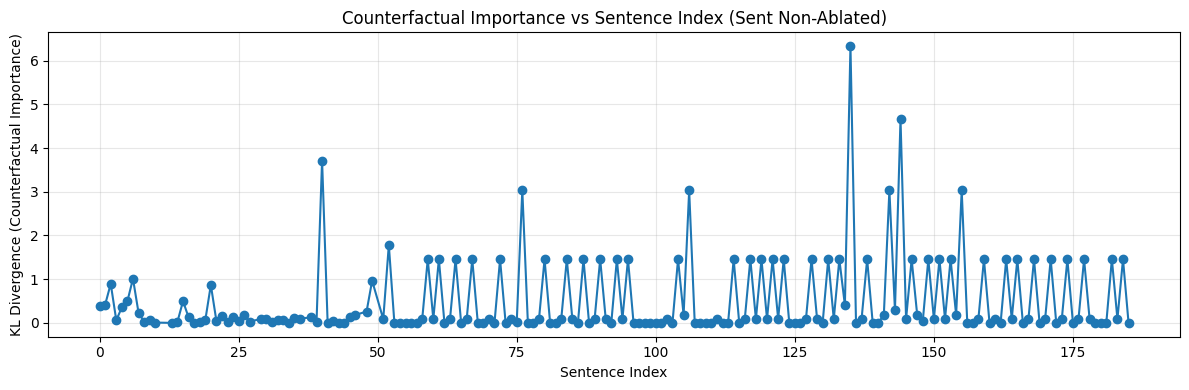

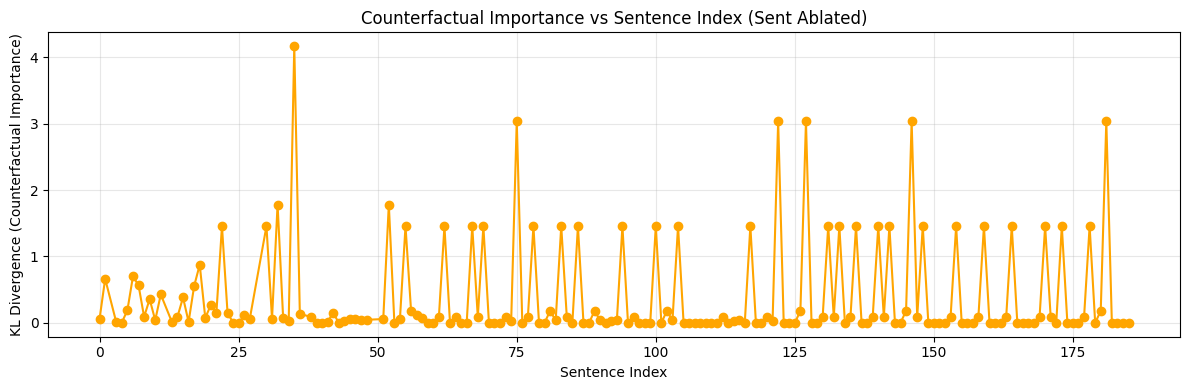

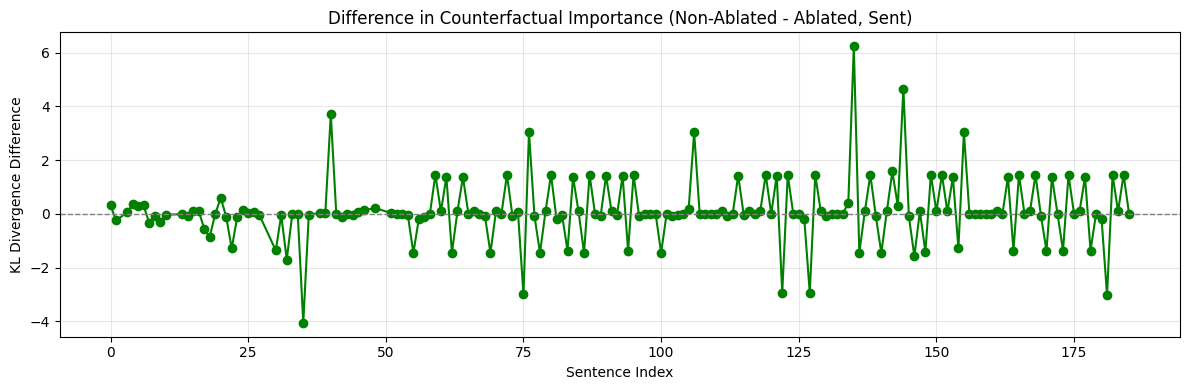

In [121]:
# Visualize counterfactual importance (KL divergence) vs sentence_idx for ablated vs non-ablated

import matplotlib.pyplot as plt
import numpy as np

# 1. Non-ablated
sentence_idx_no_ablation = [result["sentence_idx"] for result in kl_results_no_ablation_sent if "error" not in result]
kl_no_ablation = [result["kl_divergence_sent"] for result in kl_results_no_ablation_sent if "error" not in result]

# 2. Ablated
sentence_idx_ablation = [result["sentence_idx"] for result in kl_divergences_sentences_ablation_result if "error" not in result]
kl_ablation = [result["kl_divergence_sent"] for result in kl_divergences_sentences_ablation_result if "error" not in result]

# 3. Difference (align by sentence_idx)
# Build dicts for fast lookup
kl_no_ablation_dict = {idx: kl for idx, kl in zip(sentence_idx_no_ablation, kl_no_ablation)}
kl_ablation_dict = {idx: kl for idx, kl in zip(sentence_idx_ablation, kl_ablation)}
common_indices = sorted(set(kl_no_ablation_dict.keys()) & set(kl_ablation_dict.keys()))
kl_diff = [kl_no_ablation_dict[idx] - kl_ablation_dict[idx] for idx in common_indices]

# Plot 1: Non-ablated
plt.figure(figsize=(12, 4))
plt.plot(sentence_idx_no_ablation, kl_no_ablation, marker='o', label='Non-Ablated')
plt.xlabel('Sentence Index')
plt.ylabel('KL Divergence (Counterfactual Importance)')
plt.title('Counterfactual Importance vs Sentence Index (Sent Non-Ablated)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Ablated
plt.figure(figsize=(12, 4))
plt.plot(sentence_idx_ablation, kl_ablation, marker='o', color='orange', label='Ablated')
plt.xlabel('Sentence Index')
plt.ylabel('KL Divergence (Counterfactual Importance)')
plt.title('Counterfactual Importance vs Sentence Index (Sent Ablated)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Difference
plt.figure(figsize=(12, 4))
plt.plot(common_indices, kl_diff, marker='o', color='green', label='Difference (Sent Non-Ablated - Sent Ablated)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Sentence Index')
plt.ylabel('KL Divergence Difference')
plt.title('Difference in Counterfactual Importance (Non-Ablated - Ablated, Sent)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [122]:
# 1. Print KL divergence values for indices 25-50
# for idx, kl in zip(sentence_idx_no_ablation, kl_no_ablation):
#     if 25 <= idx <= 50:
        # print(f"Idx: {idx:3d} | KL: {kl:.4f}")

# 2. Print categories in that range
# print_categories_in_range(kl_results_no_ablation_sent, 25, 50)

# 3. Find the largest drop in KL divergence in that range
kl_in_range = [(idx, kl) for idx, kl in zip(sentence_idx_no_ablation, kl_no_ablation) if 25 <= idx <= 50]
drops = [(kl_in_range[i][0], kl_in_range[i][1] - kl_in_range[i+1][1]) for i in range(len(kl_in_range)-1)]
max_drop = max(drops, key=lambda x: abs(x[1]))
print(f"\nLargest drop in KL between 25-50: Sentence {max_drop[0]} with drop of {max_drop[1]:.4f}")


Largest drop in KL between 25-50: Sentence 40 with drop of 3.7115


In [123]:
print_categories_in_range(kl_results_no_ablation_sent, 100, 123)


Sentence idx range 100-123:
idx | category
100 | fact_retrieval
101 | active_computation
102 | uncertainty_management
103 | uncertainty_management
104 | fact_retrieval
105 | fact_retrieval
106 | result_consolidation
107 | uncertainty_management
108 | fact_retrieval
109 | fact_retrieval
110 | fact_retrieval
111 | uncertainty_management
112 | uncertainty_management
113 | uncertainty_management
114 | fact_retrieval
115 | fact_retrieval
116 | fact_retrieval
117 | fact_retrieval
118 | fact_retrieval
119 | fact_retrieval
120 | fact_retrieval
121 | fact_retrieval
122 | fact_retrieval
123 | fact_retrieval

Category counts: [('fact_retrieval', 16), ('uncertainty_management', 6), ('active_computation', 1), ('result_consolidation', 1)]


In [124]:
print_categories_in_range(kl_results_no_ablation_sent, 41, 50)


Sentence idx range 41-50:
idx | category
 41 | fact_retrieval
 42 | fact_retrieval
 43 | uncertainty_management
 44 | uncertainty_management
 45 | fact_retrieval
 46 | fact_retrieval
 48 | fact_retrieval
 49 | active_computation

Category counts: [('fact_retrieval', 5), ('uncertainty_management', 2), ('active_computation', 1)]


In [125]:
# --- Top 20 differences and their categories for each comparison ---
def top_diff_info(indices, diffs, results_a, results_b, label):
    abs_diffs = [abs(d) for d in diffs]
    top_20 = sorted(zip(indices, diffs, abs_diffs), key=lambda x: x[2], reverse=True)[:20]
    print(f"\nTop 20 |Difference| for {label}:")
    for idx, diff, abs_diff in top_20:
        cat_a = get_category_by_idx(idx, results_a)
        cat_b = get_category_by_idx(idx, results_b)
        print(f"Sentence {idx} | Diff: {diff:.4f} | |Diff|: {abs_diff:.4f} | Category (A): {cat_a} | Category (B): {cat_b}")

In [126]:
# Print top 20 for each difference graph
sent_removing_kurtosis_heads =top_diff_info(common_indices, kl_diff, kl_results_no_ablation_sent, kl_divergences_sentences_ablation_result, "Non-Ablated vs Ablated")


Top 20 |Difference| for Non-Ablated vs Ablated:
Sentence 135 | Diff: 6.2450 | |Diff|: 6.2450 | Category (A): result_consolidation | Category (B): result_consolidation
Sentence 144 | Diff: 4.6641 | |Diff|: 4.6641 | Category (A): active_computation | Category (B): active_computation
Sentence 35 | Diff: -4.0630 | |Diff|: 4.0630 | Category (A): fact_retrieval | Category (B): fact_retrieval
Sentence 40 | Diff: 3.7102 | |Diff|: 3.7102 | Category (A): uncertainty_management | Category (B): uncertainty_management
Sentence 76 | Diff: 3.0337 | |Diff|: 3.0337 | Category (A): active_computation | Category (B): active_computation
Sentence 106 | Diff: 3.0337 | |Diff|: 3.0337 | Category (A): result_consolidation | Category (B): result_consolidation
Sentence 155 | Diff: 3.0337 | |Diff|: 3.0337 | Category (A): fact_retrieval | Category (B): fact_retrieval
Sentence 181 | Diff: -3.0337 | |Diff|: 3.0337 | Category (A): result_consolidation | Category (B): result_consolidation
Sentence 75 | Diff: -3.0041 

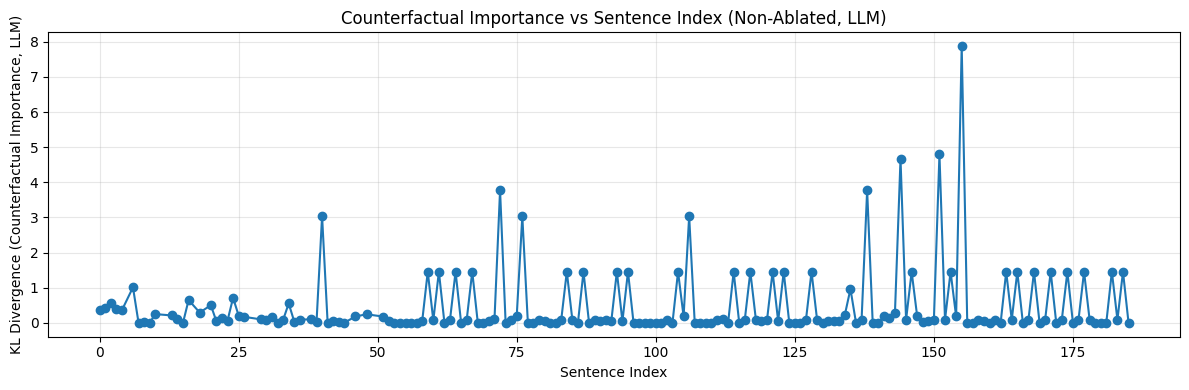

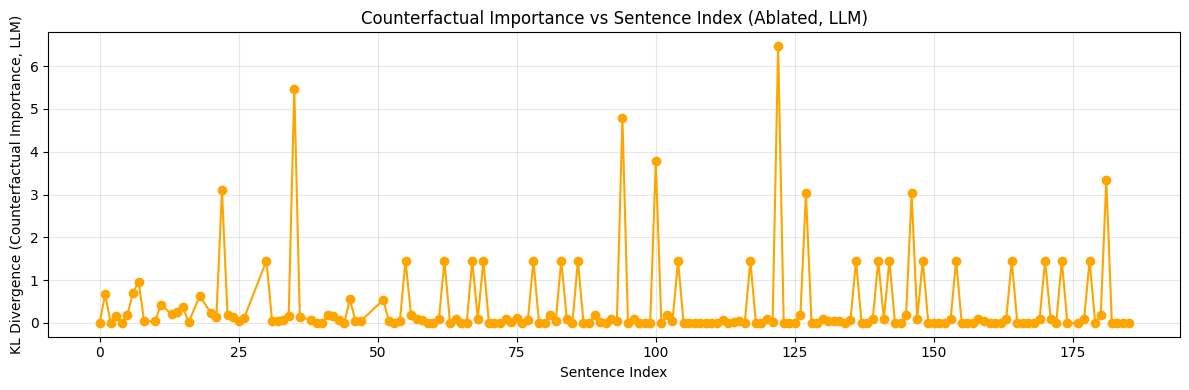

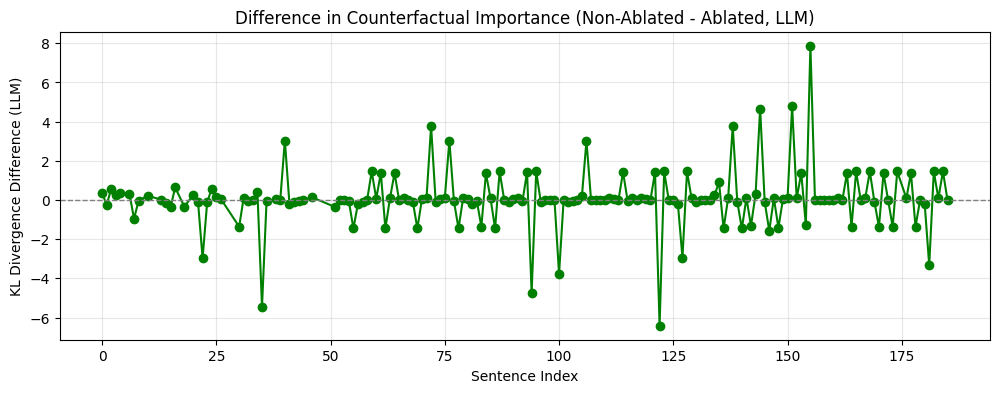

In [127]:
# Visualize counterfactual importance (KL divergence, LLM) vs sentence_idx for ablated vs non-ablated

import matplotlib.pyplot as plt
import numpy as np

# 1. Non-ablated (LLM)
sentence_idx_no_ablation_llm = [result["sentence_idx"] for result in kl_results_no_ablation_llm if "error" not in result]
kl_no_ablation_llm = [result["kl_divergence_llm"] for result in kl_results_no_ablation_llm if "error" not in result]

# 2. Ablated (LLM)
sentence_idx_ablation_llm = [result["sentence_idx"] for result in kl_divergences_llm_ablation_result if "error" not in result]
kl_ablation_llm = [result["kl_divergence_llm"] for result in kl_divergences_llm_ablation_result if "error" not in result]

# 3. Difference (align by sentence_idx)
kl_no_ablation_llm_dict = {idx: kl for idx, kl in zip(sentence_idx_no_ablation_llm, kl_no_ablation_llm)}
kl_ablation_llm_dict = {idx: kl for idx, kl in zip(sentence_idx_ablation_llm, kl_ablation_llm)}
common_indices_llm = sorted(set(kl_no_ablation_llm_dict.keys()) & set(kl_ablation_llm_dict.keys()))
kl_diff_llm = [kl_no_ablation_llm_dict[idx] - kl_ablation_llm_dict[idx] for idx in common_indices_llm]

# Plot 1: Non-ablated (LLM)
plt.figure(figsize=(12, 4))
plt.plot(sentence_idx_no_ablation_llm, kl_no_ablation_llm, marker='o', label='Non-Ablated (LLM)')
plt.xlabel('Sentence Index')
plt.ylabel('KL Divergence (Counterfactual Importance, LLM)')
plt.title('Counterfactual Importance vs Sentence Index (Non-Ablated, LLM)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Ablated (LLM)
plt.figure(figsize=(12, 4))
plt.plot(sentence_idx_ablation_llm, kl_ablation_llm, marker='o', color='orange', label='Ablated (LLM)')
plt.xlabel('Sentence Index')
plt.ylabel('KL Divergence (Counterfactual Importance, LLM)')
plt.title('Counterfactual Importance vs Sentence Index (Ablated, LLM)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Difference (LLM)
plt.figure(figsize=(12, 4))
plt.plot(common_indices_llm, kl_diff_llm, marker='o', color='green', label='Difference (Non-Ablated - Ablated, LLM)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Sentence Index')
plt.ylabel('KL Divergence Difference (LLM)')
plt.title('Difference in Counterfactual Importance (Non-Ablated - Ablated, LLM)')
plt.grid(True, alpha=0.3)

In [128]:
# Print top 20 for each difference graph
llm_removing_kurtosis_heads = top_diff_info(common_indices_llm, kl_diff_llm, kl_results_no_ablation_llm, kl_divergences_llm_ablation_result, "LLM Non-Ablated vs LLM Ablated")


Top 20 |Difference| for LLM Non-Ablated vs LLM Ablated:
Sentence 155 | Diff: 7.8730 | |Diff|: 7.8730 | Category (A): fact_retrieval | Category (B): fact_retrieval
Sentence 122 | Diff: -6.4184 | |Diff|: 6.4184 | Category (A): fact_retrieval | Category (B): fact_retrieval
Sentence 35 | Diff: -5.4404 | |Diff|: 5.4404 | Category (A): fact_retrieval | Category (B): fact_retrieval
Sentence 151 | Diff: 4.7918 | |Diff|: 4.7918 | Category (A): fact_retrieval | Category (B): fact_retrieval
Sentence 94 | Diff: -4.7473 | |Diff|: 4.7473 | Category (A): uncertainty_management | Category (B): uncertainty_management
Sentence 144 | Diff: 4.6641 | |Diff|: 4.6641 | Category (A): active_computation | Category (B): active_computation
Sentence 138 | Diff: 3.7726 | |Diff|: 3.7726 | Category (A): active_computation | Category (B): active_computation
Sentence 100 | Diff: -3.7726 | |Diff|: 3.7726 | Category (A): fact_retrieval | Category (B): fact_retrieval
Sentence 72 | Diff: 3.7726 | |Diff|: 3.7726 | Categor

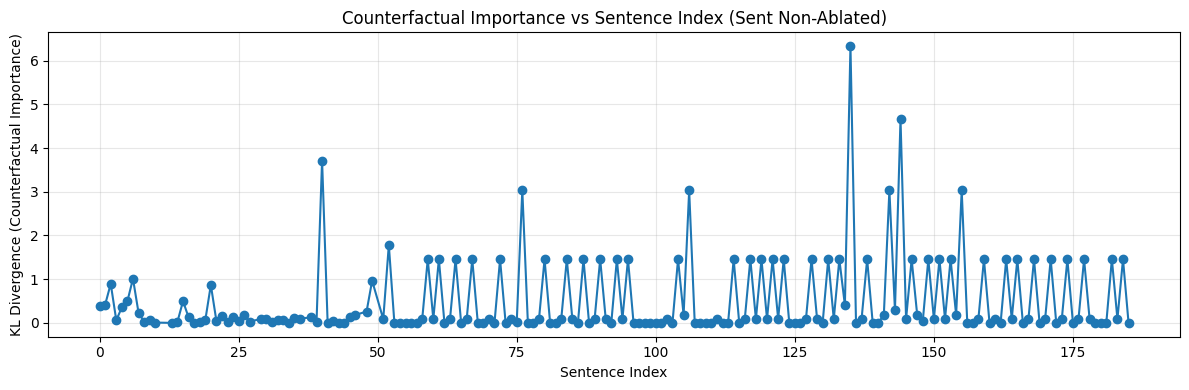

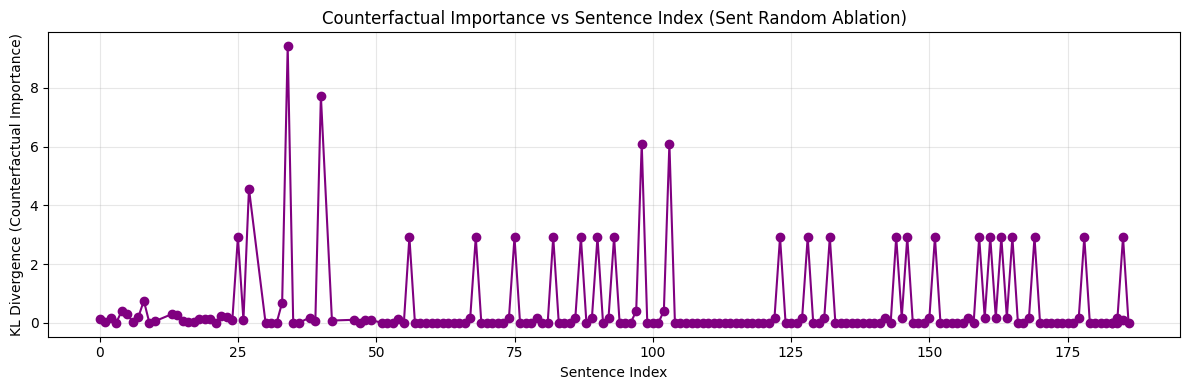

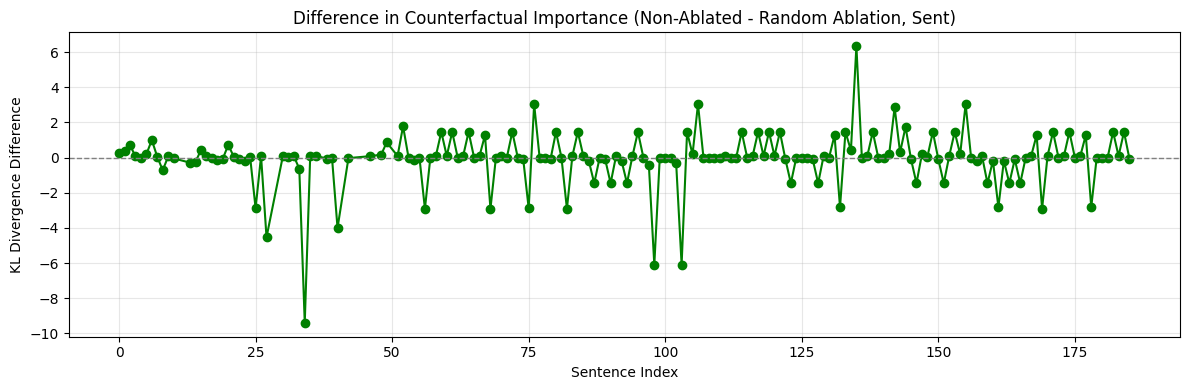

In [129]:
# Visualize counterfactual importance (KL divergence) vs sentence_idx for random ablation vs non-ablated

import matplotlib.pyplot as plt
import numpy as np

# 1. Non-ablated
sentence_idx_no_ablation = [result["sentence_idx"] for result in kl_results_no_ablation_sent if "error" not in result]
kl_no_ablation = [result["kl_divergence_sent"] for result in kl_results_no_ablation_sent if "error" not in result]

# 2. Random ablation
sentence_idx_random_ablation = [result["sentence_idx"] for result in kl_results_random_ablation_sent if "error" not in result]
kl_random_ablation = [result["kl_divergence_sent"] for result in kl_results_random_ablation_sent if "error" not in result]

# 3. Difference (align by sentence_idx)
kl_no_ablation_dict = {idx: kl for idx, kl in zip(sentence_idx_no_ablation, kl_no_ablation)}
kl_random_ablation_dict = {idx: kl for idx, kl in zip(sentence_idx_random_ablation, kl_random_ablation)}
common_indices = sorted(set(kl_no_ablation_dict.keys()) & set(kl_random_ablation_dict.keys()))
kl_diff_random = [kl_no_ablation_dict[idx] - kl_random_ablation_dict[idx] for idx in common_indices]

# Plot 1: Non-ablated
plt.figure(figsize=(12, 4))
plt.plot(sentence_idx_no_ablation, kl_no_ablation, marker='o', label='Non-Ablated')
plt.xlabel('Sentence Index')
plt.ylabel('KL Divergence (Counterfactual Importance)')
plt.title('Counterfactual Importance vs Sentence Index (Sent Non-Ablated)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Random ablation
plt.figure(figsize=(12, 4))
plt.plot(sentence_idx_random_ablation, kl_random_ablation, marker='o', color='purple', label='Random Ablation')
plt.xlabel('Sentence Index')
plt.ylabel('KL Divergence (Counterfactual Importance)')
plt.title('Counterfactual Importance vs Sentence Index (Sent Random Ablation)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Difference
plt.figure(figsize=(12, 4))
plt.plot(common_indices, kl_diff_random, marker='o', color='green', label='Difference (Non-Ablated - Random Ablation)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Sentence Index')
plt.ylabel('KL Divergence Difference')
plt.title('Difference in Counterfactual Importance (Non-Ablated - Random Ablation, Sent)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [130]:
#spike 25 - 41 not related with the behvaior of it going close to 0
print_categories_in_range(kl_results_no_ablation_sent, 25, 41)


Sentence idx range 25-41:
idx | category
 25 | fact_retrieval
 26 | fact_retrieval
 27 | fact_retrieval
 29 | active_computation
 30 | plan_generation
 31 | fact_retrieval
 32 | uncertainty_management
 33 | fact_retrieval
 34 | fact_retrieval
 35 | fact_retrieval
 36 | active_computation
 38 | uncertainty_management
 39 | fact_retrieval
 40 | uncertainty_management
 41 | fact_retrieval

Category counts: [('fact_retrieval', 9), ('uncertainty_management', 3), ('active_computation', 2), ('plan_generation', 1)]


In [131]:
print_categories_in_range(kl_results_no_ablation_sent, 41, 50)


Sentence idx range 41-50:
idx | category
 41 | fact_retrieval
 42 | fact_retrieval
 43 | uncertainty_management
 44 | uncertainty_management
 45 | fact_retrieval
 46 | fact_retrieval
 48 | fact_retrieval
 49 | active_computation

Category counts: [('fact_retrieval', 5), ('uncertainty_management', 2), ('active_computation', 1)]


In [132]:
#decrease in random only
print_categories_in_range(kl_results_no_ablation_sent, 55, 60)


Sentence idx range 55-60:
idx | category
 55 | fact_retrieval
 56 | fact_retrieval
 57 | uncertainty_management
 58 | fact_retrieval
 59 | fact_retrieval
 60 | fact_retrieval

Category counts: [('fact_retrieval', 5), ('uncertainty_management', 1)]


In [133]:
#decrease in random only
print_categories_in_range(kl_results_no_ablation_sent, 130, 140)


Sentence idx range 130-140:
idx | category
130 | fact_retrieval
131 | fact_retrieval
132 | fact_retrieval
133 | fact_retrieval
134 | fact_retrieval
135 | result_consolidation
136 | fact_retrieval
137 | active_computation
138 | active_computation
139 | result_consolidation
140 | uncertainty_management

Category counts: [('fact_retrieval', 6), ('result_consolidation', 2), ('active_computation', 2), ('uncertainty_management', 1)]


In [134]:
#decrease in random only
print_categories_in_range(kl_results_no_ablation_sent, 152, 160)


Sentence idx range 152-160:
idx | category
152 | fact_retrieval
153 | fact_retrieval
154 | fact_retrieval
155 | fact_retrieval
156 | fact_retrieval
157 | uncertainty_management
158 | uncertainty_management
159 | fact_retrieval
160 | fact_retrieval

Category counts: [('fact_retrieval', 7), ('uncertainty_management', 2)]


In [135]:
#decrease in random only
print_categories_in_range(kl_results_no_ablation_sent, 169, 175)


Sentence idx range 169-175:
idx | category
169 | fact_retrieval
170 | fact_retrieval
171 | fact_retrieval
172 | result_consolidation
173 | uncertainty_management
174 | fact_retrieval
175 | fact_retrieval

Category counts: [('fact_retrieval', 5), ('result_consolidation', 1), ('uncertainty_management', 1)]


In [136]:
# Print top 20 for each difference graph
sent_removing_random_heads = top_diff_info(common_indices, kl_diff_random, kl_results_no_ablation_sent, kl_results_random_ablation_sent, "Non-Ablated vs Random Ablated")


Top 20 |Difference| for Non-Ablated vs Random Ablated:
Sentence 34 | Diff: -9.4048 | |Diff|: 9.4048 | Category (A): fact_retrieval | Category (B): fact_retrieval
Sentence 135 | Diff: 6.3320 | |Diff|: 6.3320 | Category (A): result_consolidation | Category (B): result_consolidation
Sentence 98 | Diff: -6.1010 | |Diff|: 6.1010 | Category (A): fact_retrieval | Category (B): fact_retrieval
Sentence 103 | Diff: -6.1010 | |Diff|: 6.1010 | Category (A): uncertainty_management | Category (B): uncertainty_management
Sentence 27 | Diff: -4.5333 | |Diff|: 4.5333 | Category (A): fact_retrieval | Category (B): fact_retrieval
Sentence 40 | Diff: -4.0097 | |Diff|: 4.0097 | Category (A): uncertainty_management | Category (B): uncertainty_management
Sentence 76 | Diff: 3.0337 | |Diff|: 3.0337 | Category (A): active_computation | Category (B): active_computation
Sentence 106 | Diff: 3.0337 | |Diff|: 3.0337 | Category (A): result_consolidation | Category (B): result_consolidation
Sentence 155 | Diff: 3.0

In [137]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_category_pie_chart(top_diff_list, results, label="Top Differences", n=20):
    """
    Plot a pie chart of sentence categories in the top-N differences.
    """
    # Get the category for each idx in the top-N
    cats = [get_category_by_idx(idx, results) for idx, *_ in top_diff_list[:n]]
    cat_counts = Counter(cats)
    labels = list(cat_counts.keys())
    sizes = list(cat_counts.values())

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"(Abs Diff) Sentence Category Distribution in {label} (Top {n})")
    plt.axis('equal')
    plt.show()

In [138]:
# Count most common sentence categories in top 20 differences for each comparison

from collections import Counter

def most_common_categories(top_diff_indices, results_a, results_b, label):
    cats_a = [get_category_by_idx(idx, results_a) for idx, _, _ in top_diff_indices]
    print(f"\nMost common categories in top 20 for {label}:")
    print("Most_common:", Counter(cats_a).most_common())

# Get top 20 indices for each comparison
def get_top_diff_indices(indices, diffs):
    abs_diffs = [abs(d) for d in diffs]
    return sorted(zip(indices, diffs, abs_diffs), key=lambda x: x[2], reverse=True)[:20]

# 1. Sent Non-Ablated vs Ablated
top_sent_kurtosis = get_top_diff_indices(common_indices, kl_diff)
most_common_categories(top_sent_kurtosis, kl_results_no_ablation_sent, kl_divergences_sentences_ablation_result, "Sent Non-Ablated vs Ablated")

# 2. LLM Non-Ablated vs Ablated
top_llm_kurtosis = get_top_diff_indices(common_indices_llm, kl_diff_llm)
most_common_categories(top_llm_kurtosis, kl_results_no_ablation_llm, kl_divergences_llm_ablation_result, "LLM Non-Ablated vs Ablated")

# 3. Sent Non-Ablated vs Random Ablated
top_sent_random = get_top_diff_indices(common_indices, kl_diff_random)
most_common_categories(top_sent_random, kl_results_no_ablation_sent, kl_results_random_ablation_sent, "Sent Non-Ablated vs Random Ablated")


Most common categories in top 20 for Sent Non-Ablated vs Ablated:
Most_common: [('fact_retrieval', 7), ('active_computation', 5), ('result_consolidation', 3), ('plan_generation', 3), ('uncertainty_management', 2)]

Most common categories in top 20 for LLM Non-Ablated vs Ablated:
Most_common: [('fact_retrieval', 11), ('uncertainty_management', 3), ('active_computation', 3), ('result_consolidation', 2), ('plan_generation', 1)]

Most common categories in top 20 for Sent Non-Ablated vs Random Ablated:
Most_common: [('fact_retrieval', 13), ('uncertainty_management', 3), ('result_consolidation', 2), ('active_computation', 2)]


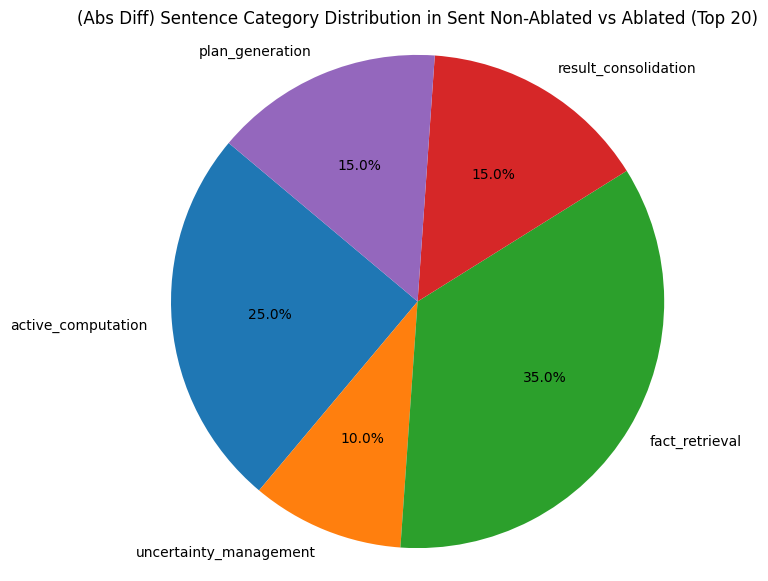

In [139]:
# Example usage:
plot_category_pie_chart(top_sent_kurtosis, kl_results_no_ablation_sent, label="Sent Non-Ablated vs Ablated", n=20)

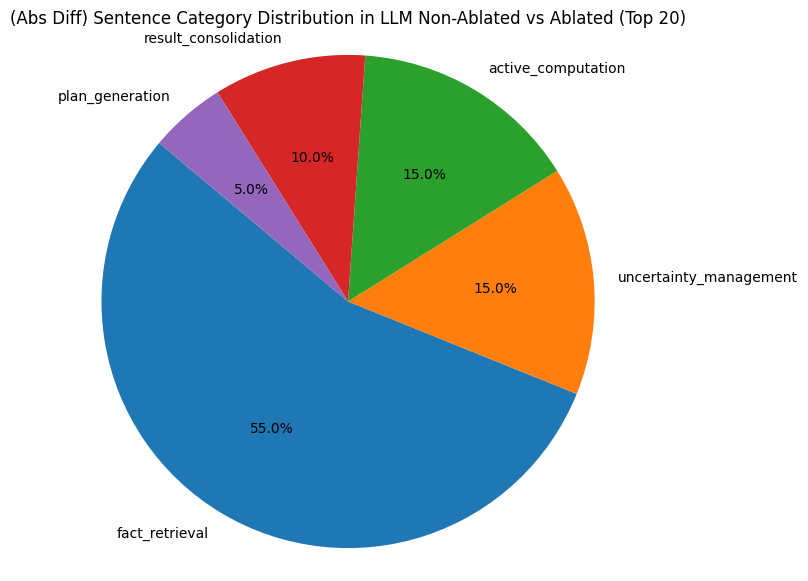

In [140]:
# Example usage:
plot_category_pie_chart(top_llm_kurtosis, kl_results_no_ablation_sent, label="LLM Non-Ablated vs Ablated", n=20)

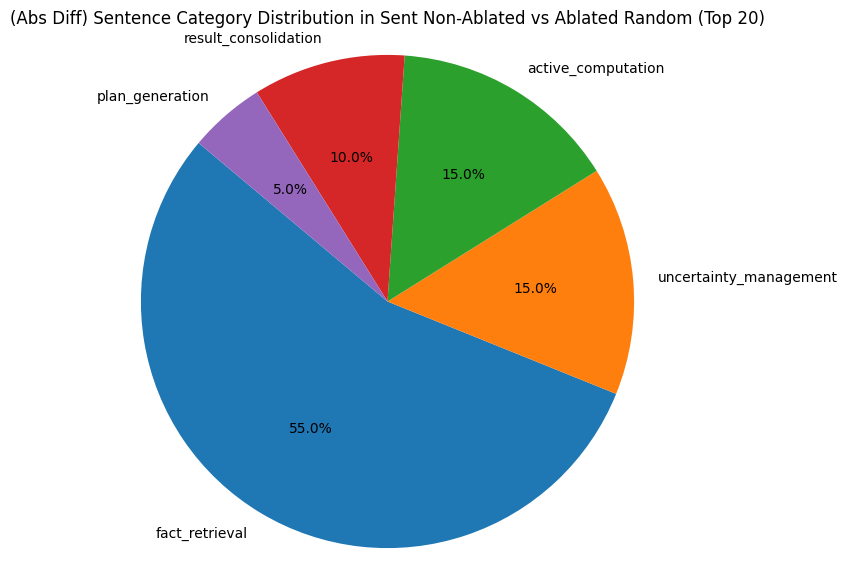

In [141]:
# Random Ablation:
plot_category_pie_chart(top_llm_kurtosis, kl_results_no_ablation_sent, label="Sent Non-Ablated vs Ablated Random", n=20)

In [142]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_category_pie_chart_lowest(top_diff_list, results, label="Top Differences", n=20):
    """
    Plot a pie chart of sentence categories in the top-N differences.
    """
    # Get the category for each idx in the top-N
    cats = [get_category_by_idx(idx, results) for idx, *_ in top_diff_list[:n]]
    cat_counts = Counter(cats)
    labels = list(cat_counts.keys())
    sizes = list(cat_counts.values())

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"(Abs Diff) Sentence Category Distribution in {label} (Lowest {n})")
    plt.axis('equal')
    plt.show()

In [143]:
# Count most common sentence categories in top 20 differences for each comparison

from collections import Counter

def most_common_categories(top_diff_indices, results_a, results_b, label):
    cats_a = [get_category_by_idx(idx, results_a) for idx, _, _ in top_diff_indices]
    print(f"\nMost common categories in top 20 for {label}:")
    print("Most_common:", Counter(cats_a).most_common())

# Get top 20 indices for each comparison
def get_low_diff_indices(indices, diffs):
    abs_diffs = [abs(d) for d in diffs]
    return sorted(zip(indices, diffs, abs_diffs), key=lambda x: x[2])[:20]

# 1. Sent Non-Ablated vs Ablated
low_sent_kurtosis = get_low_diff_indices(common_indices, kl_diff)
most_common_categories(low_sent_kurtosis, kl_results_no_ablation_sent, kl_divergences_sentences_ablation_result, "Sent Non-Ablated vs Ablated")

# 2. LLM Non-Ablated vs Ablated
low_llm_kurtosis = get_low_diff_indices(common_indices_llm, kl_diff_llm)
most_common_categories(low_llm_kurtosis, kl_results_no_ablation_llm, kl_divergences_llm_ablation_result, "LLM Non-Ablated vs Ablated")

# 3. Sent Non-Ablated vs Random Ablated
low_sent_random = get_low_diff_indices(common_indices, kl_diff_random)
most_common_categories(low_sent_random, kl_results_no_ablation_sent, kl_results_random_ablation_sent, "Sent Non-Ablated vs Random Ablated")


Most common categories in top 20 for Sent Non-Ablated vs Ablated:
Most_common: [('fact_retrieval', 13), ('uncertainty_management', 3), ('active_computation', 2), ('plan_generation', 1), ('result_consolidation', 1)]

Most common categories in top 20 for LLM Non-Ablated vs Ablated:
Most_common: [('fact_retrieval', 14), ('uncertainty_management', 3), ('active_computation', 2), ('plan_generation', 1)]

Most common categories in top 20 for Sent Non-Ablated vs Random Ablated:
Most_common: [('fact_retrieval', 14), ('uncertainty_management', 3), ('active_computation', 2), ('result_consolidation', 1)]


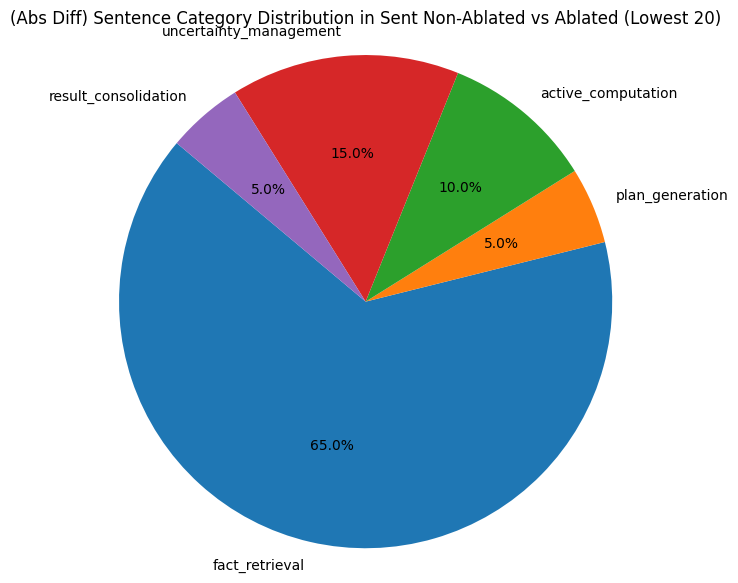

In [144]:
plot_category_pie_chart_lowest(low_sent_kurtosis, kl_results_no_ablation_sent, label="Sent Non-Ablated vs Ablated", n=20)

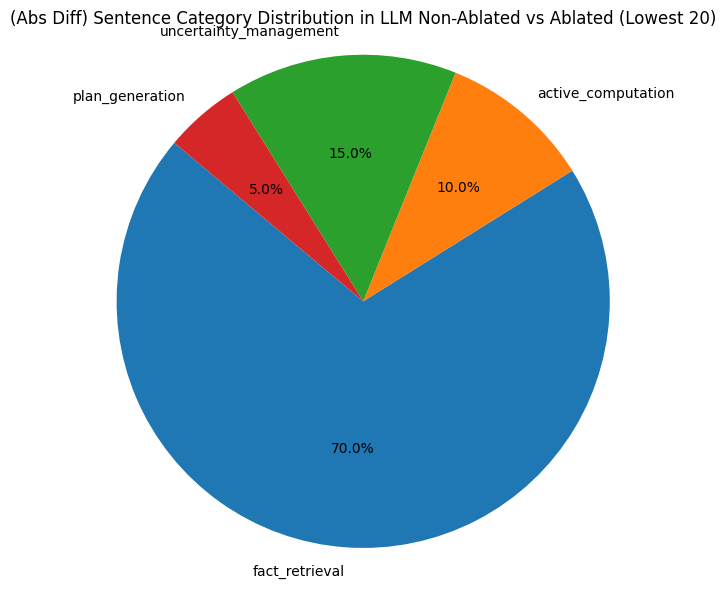

In [145]:
plot_category_pie_chart_lowest(low_llm_kurtosis, kl_results_no_ablation_sent, label="LLM Non-Ablated vs Ablated", n=20)

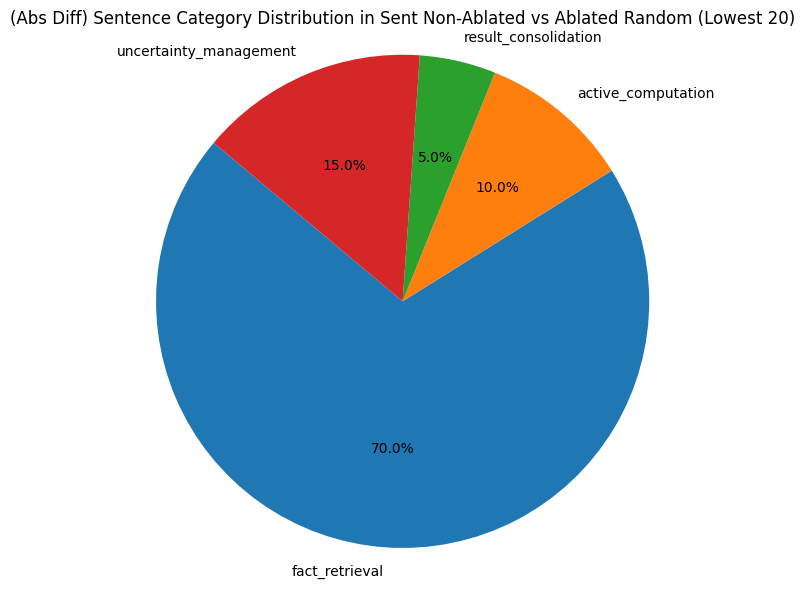

In [146]:
plot_category_pie_chart_lowest(low_sent_random, kl_results_no_ablation_sent, label="Sent Non-Ablated vs Ablated Random", n=20)

In [147]:
# Print all plan_generation sentences in the top 20 differences (Sent Non-Ablated vs Ablated)
print("\nPlan Generation sentences in top 20 differences (Sent Non-Ablated vs Ablated):")
for idx, diff, abs_diff in top_sent_kurtosis:
    cat = get_category_by_idx(idx, kl_results_no_ablation_sent)
    if cat == "plan_generation":
        # Find the sentence text from the original rollouts
        text = ""
        for r in sentence_rollouts_no_ablation:
            if r.get("sentence_idx") == idx:
                text = r.get("sentence_text", "")
                break
        print(f"Idx: {idx} | Diff: {diff:.4f} | Text: {text}")


Plan Generation sentences in top 20 differences (Sent Non-Ablated vs Ablated):
Idx: 124 | Diff: -2.9467 | Text: Wait, maybe I should try to figure out the exact path.
Idx: 64 | Diff: -1.4553 | Text: Wait, let me try to figure out how many straight segments there are.
Idx: 80 | Diff: -1.4553 | Text: Let me check again.


In [148]:
# Print all plan_generation sentences in the top 20 differences (Sent Non-Ablated vs Ablated)
print("\nPlan Generation sentences in top 20 differences (Sent Non-Ablated vs Ablated):")
for idx, diff, abs_diff in top_sent_kurtosis:
    cat = get_category_by_idx(idx, kl_results_no_ablation_sent)
    if cat == "fact_retrieval":
        # Find the sentence text from the original rollouts
        text = ""
        for r in sentence_rollouts_no_ablation:
            if r.get("sentence_idx") == idx:
                text = r.get("sentence_text", "")
                break
        print(f"Idx: {idx} | Diff: {diff:.4f} | Text: {text}")


Plan Generation sentences in top 20 differences (Sent Non-Ablated vs Ablated):
Idx: 34 | Diff: -4.0630 | Text: Each arc seems to connect points on adjacent sides.
Idx: 39 | Diff: 3.7102 | Text: Each corner has an arc: starting from (0,0), the arc goes from (3,0) to (0,3).
Idx: 108 | Diff: 3.0337 | Text: Wait, if I think about the figure, it's similar to a square with its corners replaced by quarter-circles.
Idx: 129 | Diff: -2.9467 | Text: - Arc from (3,3) radius 1, from 180 to 270 degrees: which is from (3,2) to (2,3).
Idx: 31 | Diff: -1.7072 | Text: From the Asymptote code, it seems like there are four arcs, each on a different side.
Idx: 71 | Diff: -1.4553 | Text: But in our problem, the side is 9 units, divided into three parts of 3 each.
Idx: 82 | Diff: 1.4553 | Text: - Arc from (0,0) radius 1 from 0 to 90 degrees: so that's a quarter-circle.


In [149]:
# Print all plan_generation sentences in the top 20 differences (LLM Non-Ablated vs Ablated)
print("\nPlan Generation sentences in top 20 differences (LLM Non-Ablated vs Ablated):")
for idx, diff, abs_diff in top_llm_kurtosis:
    cat = get_category_by_idx(idx, kl_results_no_ablation_llm)
    if cat == "plan_generation":
        # Find the sentence text from the original rollouts
        text = ""
        for r in sentence_rollouts_no_ablation:
            if r.get("sentence_idx") == idx:
                text = r.get("sentence_text", "")
                break
        print(f"Idx: {idx} | Diff: {diff:.4f} | Text: {text}")


Plan Generation sentences in top 20 differences (LLM Non-Ablated vs Ablated):
Idx: 22 | Diff: -2.9761 | Text: Let me parse it.


In [150]:
# Print all plan_generation sentences in the top 20 differences (LLM Non-Ablated vs Ablated)
print("\nPlan Generation sentences in top 20 differences (LLM Non-Ablated vs Ablated):")
for idx, diff, abs_diff in top_llm_kurtosis:
    cat = get_category_by_idx(idx, kl_results_no_ablation_llm)
    if cat == "fact_retrieval":
        # Find the sentence text from the original rollouts
        text = ""
        for r in sentence_rollouts_no_ablation:
            if r.get("sentence_idx") == idx:
                text = r.get("sentence_text", "")
                break
        print(f"Idx: {idx} | Diff: {diff:.4f} | Text: {text}")


Plan Generation sentences in top 20 differences (LLM Non-Ablated vs Ablated):
Idx: 155 | Diff: 7.8730 | Text: - Then a straight segment between the two division points.
Idx: 122 | Diff: -6.4184 | Text: So, for instance, near corner A, there are two arcs: one connecting P to R and another connecting Q to S.
Idx: 35 | Diff: -5.4404 | Text: So, each arc is a quarter-circle with radius 3 units.
Idx: 151 | Diff: 4.7918 | Text: So, each side contributes two segments: a straight segment in the middle and an arc at each end.
Idx: 100 | Diff: -3.7726 | Text: Each straight segment is 3 units, four segments: 12 units.
Idx: 72 | Diff: 3.7726 | Text: So, the straight segments are 3 units each.
Idx: 127 | Diff: -2.9467 | Text: - Then, arc from (0,3) radius 1, from 0 to -90 degrees: which is from (0,2) to (1,3).
Idx: 55 | Diff: -1.4553 | Text: Looking at the Asymptote code:
Idx: 59 | Diff: 1.4553 | Text: So, scaling up by a factor of 3.
Idx: 62 | Diff: -1.4553 | Text: But in the Asymptote code, it a

In [151]:
from collections import Counter

def most_common_categories(top_diff_indices, results_a, results_b, label):
    cats_a = [get_category_by_idx(idx, results_a) for idx, _ in top_diff_indices]
    print(f"\nMost common categories in top 20 for {label}:")
    print("Most_common:", Counter(cats_a).most_common())

def get_lowest_diff_indices(indices, diffs, n=20):
    # Most negative (increase)
    return sorted(zip(indices, diffs), key=lambda x: x[1])[:n]

def get_highest_diff_indices(indices, diffs, n=20):
    # Most positive (decrease)
    return sorted(zip(indices, diffs), key=lambda x: x[1], reverse=True)[:n]

# Example for Sent Non-Ablated vs Ablated
lowest_sent = get_lowest_diff_indices(common_indices, kl_diff)
highest_sent = get_highest_diff_indices(common_indices, kl_diff)
most_common_categories(lowest_sent, kl_results_no_ablation_sent, kl_divergences_sentences_ablation_result, "Sent Non-Ablated vs Ablated (Lowest/Increase)")
most_common_categories(highest_sent, kl_results_no_ablation_sent, kl_divergences_sentences_ablation_result, "Sent Non-Ablated vs Ablated (Highest/Decrease)")

# Example for LLM Non-Ablated vs Ablated
lowest_llm = get_lowest_diff_indices(common_indices_llm, kl_diff_llm)
highest_llm = get_highest_diff_indices(common_indices_llm, kl_diff_llm)
most_common_categories(lowest_llm, kl_results_no_ablation_llm, kl_divergences_llm_ablation_result, "LLM Non-Ablated vs Ablated (Lowest/Increase)")
most_common_categories(highest_llm, kl_results_no_ablation_llm, kl_divergences_llm_ablation_result, "LLM Non-Ablated vs Ablated (Highest/Decrease)")

# Example for Sent Non-Ablated vs Random Ablated
lowest_sent_random = get_lowest_diff_indices(common_indices, kl_diff_random)
highest_sent_random = get_highest_diff_indices(common_indices, kl_diff_random)
most_common_categories(lowest_sent_random, kl_results_no_ablation_sent, kl_results_random_ablation_sent, "Sent Non-Ablated vs Random Ablated (Lowest/Increase)")
most_common_categories(highest_sent_random, kl_results_no_ablation_sent, kl_results_random_ablation_sent, "Sent Non-Ablated vs Random Ablated (Highest/Decrease)")


Most common categories in top 20 for Sent Non-Ablated vs Ablated (Lowest/Increase):
Most_common: [('fact_retrieval', 9), ('result_consolidation', 4), ('plan_generation', 3), ('active_computation', 2), ('uncertainty_management', 2)]

Most common categories in top 20 for Sent Non-Ablated vs Ablated (Highest/Decrease):
Most_common: [('fact_retrieval', 11), ('active_computation', 4), ('uncertainty_management', 4), ('result_consolidation', 1)]

Most common categories in top 20 for LLM Non-Ablated vs Ablated (Lowest/Increase):
Most_common: [('fact_retrieval', 12), ('uncertainty_management', 4), ('result_consolidation', 3), ('plan_generation', 1)]

Most common categories in top 20 for LLM Non-Ablated vs Ablated (Highest/Decrease):
Most_common: [('fact_retrieval', 12), ('active_computation', 3), ('result_consolidation', 3), ('uncertainty_management', 2)]

Most common categories in top 20 for Sent Non-Ablated vs Random Ablated (Lowest/Increase):
Most_common: [('fact_retrieval', 14), ('uncertai

In [153]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_category_pie_chart_decrease(top_diff_list, results, label="Top Differences", n=20):
    """
    Plot a pie chart of sentence categories in the top-N differences.
    """
    # Get the category for each idx in the top-N
    cats = [get_category_by_idx(idx, results) for idx, *_ in top_diff_list[:n]]
    cat_counts = Counter(cats)
    labels = list(cat_counts.keys())
    sizes = list(cat_counts.values())

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"Sentence Category Distribution in {label} (Top Decrease {n})")
    plt.axis('equal')
    plt.show()

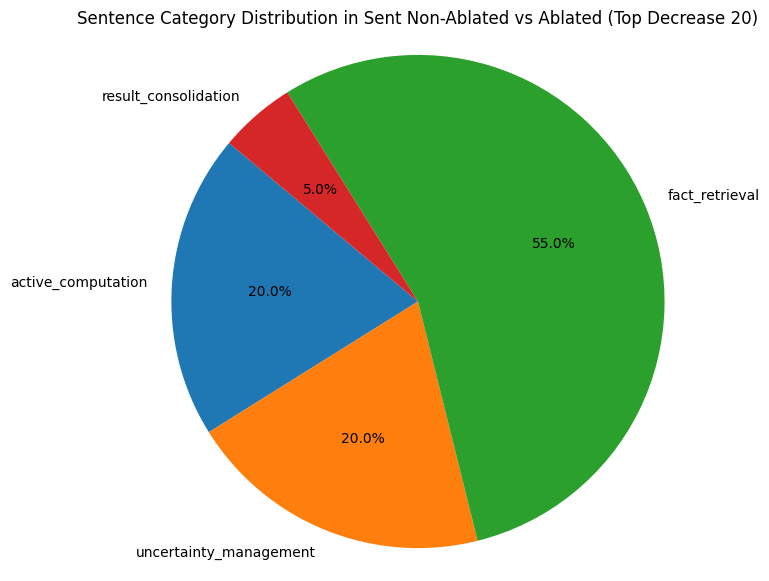

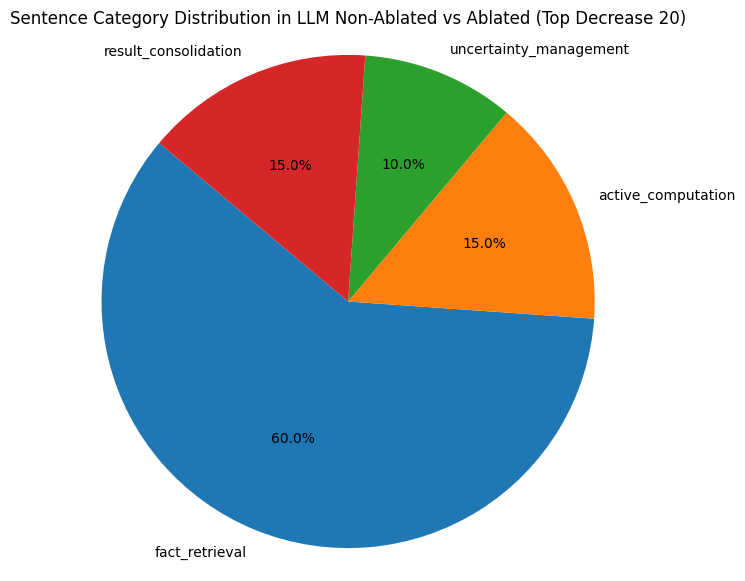

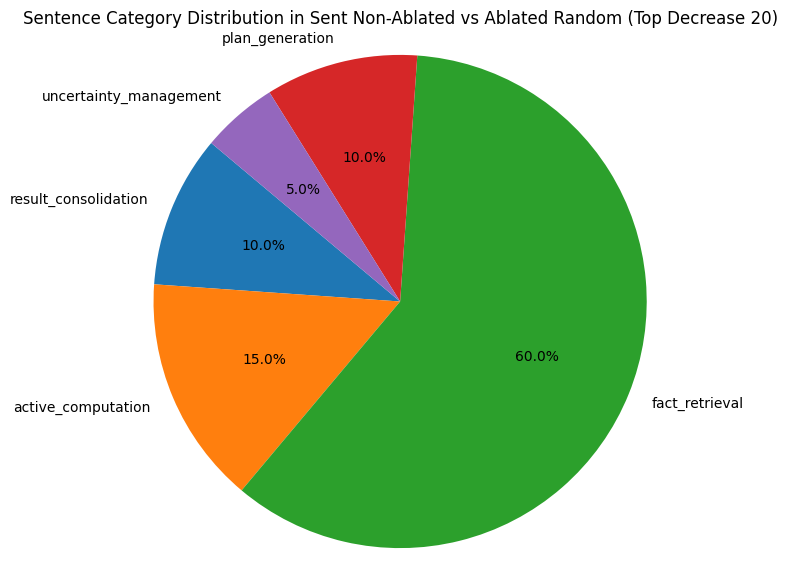

In [154]:
plot_category_pie_chart_decrease(highest_sent, kl_results_no_ablation_sent, label="Sent Non-Ablated vs Ablated", n=20)
plot_category_pie_chart_decrease(highest_llm, kl_results_no_ablation_sent, label="LLM Non-Ablated vs Ablated", n=20)
plot_category_pie_chart_decrease(highest_sent_random, kl_results_no_ablation_sent, label="Sent Non-Ablated vs Ablated Random", n=20)

In [156]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_category_pie_chart_increase(top_diff_list, results, label="Top Differences", n=20):
    """
    Plot a pie chart of sentence categories in the top-N differences.
    """
    # Get the category for each idx in the top-N
    cats = [get_category_by_idx(idx, results) for idx, *_ in top_diff_list[:n]]
    cat_counts = Counter(cats)
    labels = list(cat_counts.keys())
    sizes = list(cat_counts.values())

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f"Sentence Category Distribution in {label} (Top Increase {n})")
    plt.axis('equal')
    plt.show()

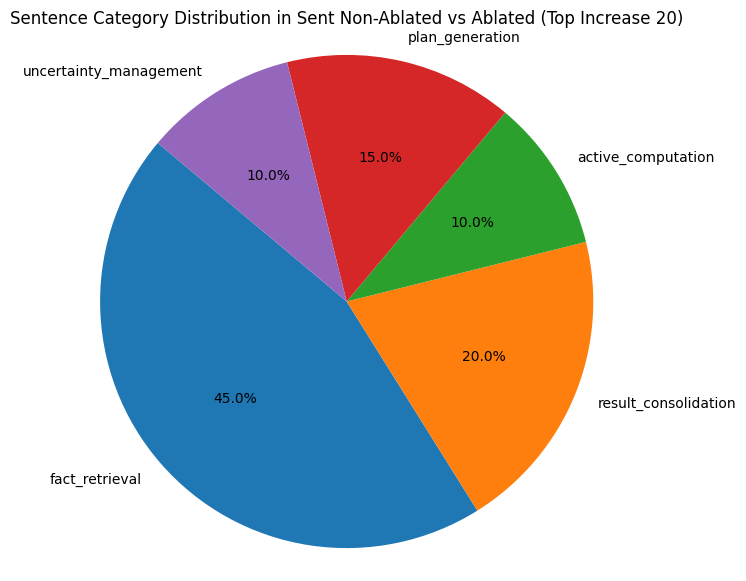

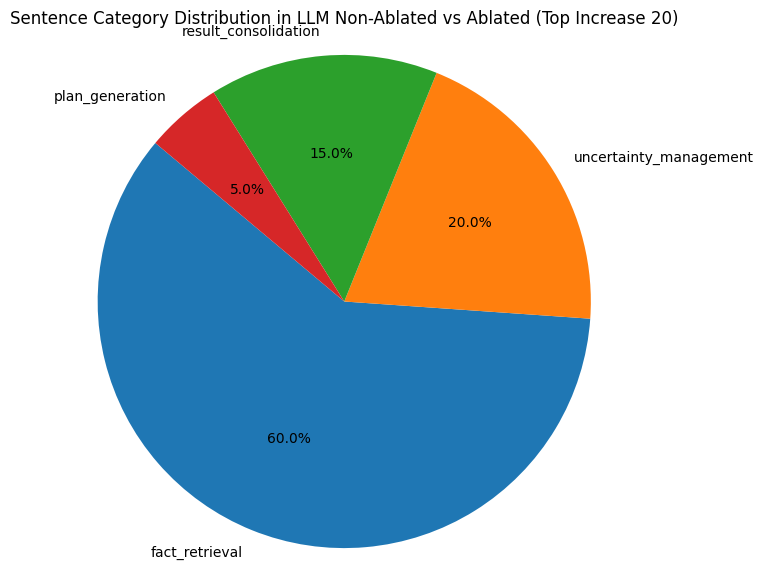

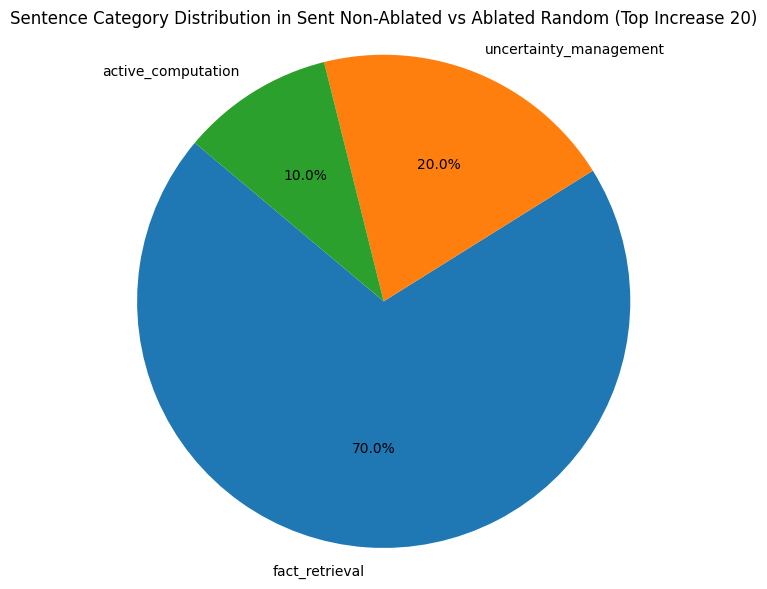

In [157]:
plot_category_pie_chart_increase(lowest_sent, kl_results_no_ablation_sent, label="Sent Non-Ablated vs Ablated", n=20)
plot_category_pie_chart_increase(lowest_llm, kl_results_no_ablation_sent, label="LLM Non-Ablated vs Ablated", n=20)
plot_category_pie_chart_increase(lowest_sent_random, kl_results_no_ablation_sent, label="Sent Non-Ablated vs Ablated Random", n=20)

In [152]:
# Print all plan_generation sentences in the top 20 differences (Sent Non-Ablated vs Ablated)
print("\nPlan Generation sentences in top 20 differences (Sent Non-Ablated vs Ablated, Lowest/Increase):")
for idx, diff in lowest_sent:
    cat = get_category_by_idx(idx, kl_results_no_ablation_sent)
    if cat == "plan_generation":
        text = ""
        for r in sentence_rollouts_no_ablation:
            if r.get("sentence_idx") == idx:
                text = r.get("sentence_text", "")
                break
        print(f"Idx: {idx} | Diff: {diff:.4f} | Text: {text}")

print("\nPlan Generation sentences in top 20 differences (Sent Non-Ablated vs Ablated, Highest/Decrease):")
for idx, diff in highest_sent:
    cat = get_category_by_idx(idx, kl_results_no_ablation_sent)
    if cat == "plan_generation":
        text = ""
        for r in sentence_rollouts_no_ablation:
            if r.get("sentence_idx") == idx:
                text = r.get("sentence_text", "")
                break
        print(f"Idx: {idx} | Diff: {diff:.4f} | Text: {text}")


Plan Generation sentences in top 20 differences (Sent Non-Ablated vs Ablated, Lowest/Increase):
Idx: 124 | Diff: -2.9467 | Text: Wait, maybe I should try to figure out the exact path.
Idx: 64 | Diff: -1.4553 | Text: Wait, let me try to figure out how many straight segments there are.
Idx: 80 | Diff: -1.4553 | Text: Let me check again.

Plan Generation sentences in top 20 differences (Sent Non-Ablated vs Ablated, Highest/Decrease):
